In [7]:
import pandas as pd
from google.cloud import bigquery
import os 

Authentication

In [8]:
user_id = 'limayk'
training_gcp_project = 'soe-nero-phi-barbarae-llmc' #Your own Nero GCP project where you have access
source_project_id = 'som-rit-phi-starr-prod' #The project where the data is stored
dataset_id = 'starr_omop_cdm5_confidential_1pcent_latest' #The dataset in the source project

In [9]:
#set credentials
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = f'/Users/kalyanilimaye/.config/gcloud/application_default_credentials.json' 

#set project
os.environ['GCLOUD_PROJECT'] = training_gcp_project #Set the active project (your own Nero project)

#set client
client = bigquery.Client(project=training_gcp_project) #Initialize BigQuery Client (in your own Nero project)

#verify
print("Authenticated Project:", client.project) #Verify authentication

Authenticated Project: soe-nero-phi-barbarae-llmc


In [10]:
import random
import torch
import numpy as np

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)  # Call before training

## Meds

In [11]:
meds_omop = [1718735, 1718737, 1718750, 1718752, 19079322] 

mapping_query = f"""
SELECT
  concept_id,
  concept_name
FROM
  `som-rit-phi-starr-prod.starr_omop_cdm5_confidential_1pcent_latest.concept`
WHERE
  concept_id IN ({','.join(map(str, meds_omop))})
ORDER BY
  concept_id
"""
df_mapping = client.query(mapping_query).to_dataframe()
display(df_mapping)

,concept_id,concept_name
0,1718735,100 ML potassium chloride 0.2 MEQ/ML Injection
1,1718737,50 ML potassium chloride 0.2 MEQ/ML Injection
2,1718750,100 ML potassium chloride 0.4 MEQ/ML Injection
3,1718752,50 ML potassium chloride 0.4 MEQ/ML Injection
4,19079322,100 ML potassium chloride 0.1 MEQ/ML Injection


In [12]:
query_meds = f"""
SELECT *
FROM
  `som-rit-phi-starr-prod.starr_omop_cdm5_confidential_1pcent_latest.drug_exposure`
WHERE
  drug_concept_id IN ({','.join(map(str, meds_omop))})
"""
df_meds = client.query(query_meds).to_dataframe()
subject_ids = df_meds['person_id'].unique().tolist()
print(f"Number of subjects with potassium meds: {len(subject_ids)}")
display(df_meds.head(2))

Number of subjects with potassium meds: 758


,drug_exposure_id,person_id,drug_concept_id,drug_exposure_start_DATE,drug_exposure_start_DATETIME,drug_exposure_end_DATE,drug_exposure_end_DATETIME,verbatim_end_DATE,drug_type_concept_id,stop_reason,...,provider_id,visit_occurrence_id,visit_detail_id,drug_source_value,drug_source_concept_id,route_source_value,dose_unit_source_value,trace_id,unit_id,load_table_id
0,30827288,43707146,19079322,2020-07-28,2020-07-28 06:43:00,2020-07-28,2020-07-28 06:43:00,2020-07-28,32818,None,...,1103708,223835139,<NA>,312507,19079322,IV,mEq,None,drug.rule.1.lpch_mar_admin_info_non_IV,lpch_mar_admin_info
1,21156453,120075364,1718752,2024-03-30,2024-03-30 01:30:00,2024-03-30,2024-03-30 01:34:00,2024-03-30,32818,Patient Discharge,...,1022911,239344995,<NA>,1860466,1718752,Intravenous,mL,None,drug.rule.1.shc_mar_admin_info_IV,shc_mar_admin_info


In [13]:
#Hardcode mapping of concept_id to dose_bucket (mEq per full container)
dose_mapping = {
    1718735: 20,   # 100 mL × 0.2 mEq/mL = 20 mEq
    1718737: 10,   # 50 mL × 0.2 mEq/mL = 10 mEq
    1718750: 40,   # 100 mL × 0.4 mEq/mL = 40 mEq
    1718752: 20,   # 50 mL × 0.4 mEq/mL = 20 mEq
    19079322: 10   # 100 mL × 0.1 mEq/mL = 10 mEq
}

meds_admin = df_meds.copy()
#Add the dose_bucket column -> similar to MIMIC
meds_admin['dose_bucket'] = df_meds['drug_concept_id'].map(dose_mapping)


In [14]:
meds_admin.head(2)

,drug_exposure_id,person_id,drug_concept_id,drug_exposure_start_DATE,drug_exposure_start_DATETIME,drug_exposure_end_DATE,drug_exposure_end_DATETIME,verbatim_end_DATE,drug_type_concept_id,stop_reason,...,visit_occurrence_id,visit_detail_id,drug_source_value,drug_source_concept_id,route_source_value,dose_unit_source_value,trace_id,unit_id,load_table_id,dose_bucket
0,30827288,43707146,19079322,2020-07-28,2020-07-28 06:43:00,2020-07-28,2020-07-28 06:43:00,2020-07-28,32818,None,...,223835139,<NA>,312507,19079322,IV,mEq,None,drug.rule.1.lpch_mar_admin_info_non_IV,lpch_mar_admin_info,10
1,21156453,120075364,1718752,2024-03-30,2024-03-30 01:30:00,2024-03-30,2024-03-30 01:34:00,2024-03-30,32818,Patient Discharge,...,239344995,<NA>,1860466,1718752,Intravenous,mL,None,drug.rule.1.shc_mar_admin_info_IV,shc_mar_admin_info,20


## Labs
Final list here is subjects who received a potassium-related medication AND have a atleast one potassium lab measurement

In [15]:
labs_omop = [3023103, 3005456] #mmol -> consistent measurement

every measurement (lab) for those patients receiving KCl and have atleast one of the labs above

In [16]:
#we do all this directly in BQ bc its way quicker
query_labs = f"""
WITH meds AS (
  SELECT DISTINCT person_id
  FROM `som-rit-phi-starr-prod.starr_omop_cdm5_confidential_1pcent_latest.drug_exposure`
  WHERE person_id IN ({','.join(map(str, subject_ids))})
),
labs AS (
  SELECT DISTINCT person_id
  FROM `som-rit-phi-starr-prod.starr_omop_cdm5_confidential_1pcent_latest.measurement`
  WHERE measurement_concept_id IN ({','.join(map(str, labs_omop))})
),
subjects AS (
  SELECT person_id FROM meds
  INTERSECT DISTINCT
  SELECT person_id FROM labs
)
SELECT *
FROM
  `som-rit-phi-starr-prod.starr_omop_cdm5_confidential_1pcent_latest.measurement`
WHERE
  person_id IN (SELECT person_id FROM subjects)
"""
all_labs = client.query(query_labs).to_dataframe()
print("Retrieved", len(all_labs), "measurement records for subjects meeting both criteria.")


Retrieved 9927194 measurement records for subjects meeting both criteria.


only KCl labs for those subjects

In [17]:
df_potassium_lab = all_labs[
    all_labs['measurement_concept_id'].isin(labs_omop)
]
len(df_potassium_lab)

55845

Some notes:
- 99th percentile is 7.5, so remove everything above that to filter outliers
- some rows are in mmol/L and some are in meq/L but since Potassium is a monovalent ion (valence = +1), 1 mmol of K⁺ carries exactly 1 mEq of charge so they're equivalent

In [18]:
labs_taken = df_potassium_lab[df_potassium_lab['value_as_number'] <= 7.5]

In [19]:
subject_ids = labs_taken['person_id'].unique().tolist()
print("Number of subjects with at least one potassium lab measurement:", len(subject_ids))

Number of subjects with at least one potassium lab measurement: 758


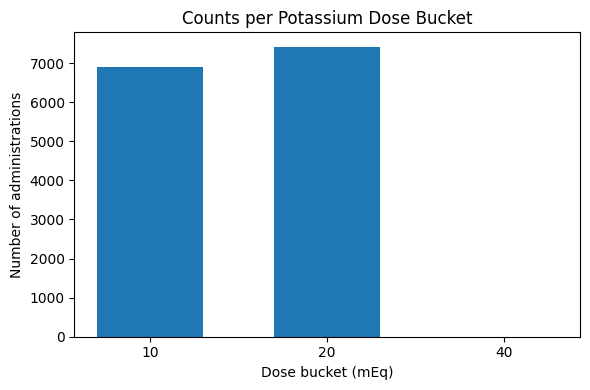

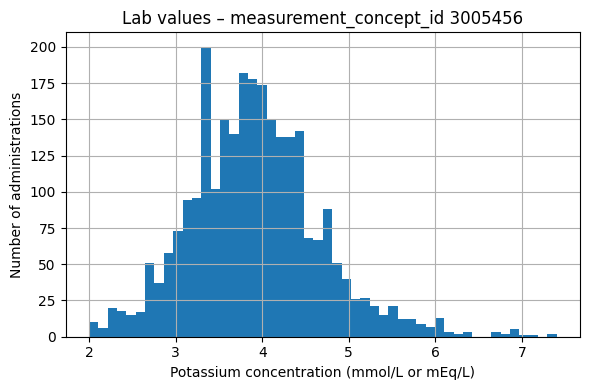

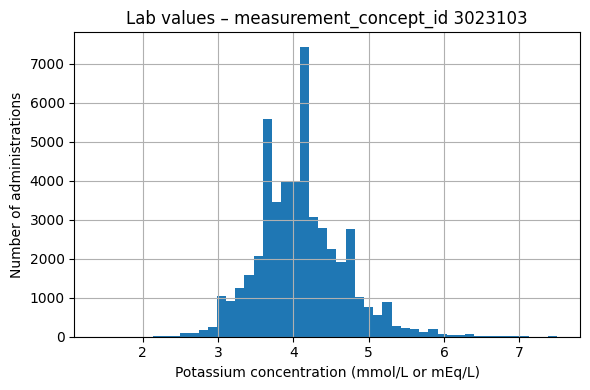

In [20]:
import matplotlib.pyplot as plt

# 1) Medication dose buckets histogram
counts = meds_admin['dose_bucket'].dropna().value_counts().sort_index()
plt.figure(figsize=(6,4))
plt.bar(counts.index.astype(str), counts.values, width=0.6)
plt.xlabel("Dose bucket (mEq)")
plt.ylabel("Number of administrations")
plt.title("Counts per Potassium Dose Bucket")
plt.tight_layout()
plt.show()

# 2) Potassium lab value histograms by concept
for mcid in labs_taken['measurement_concept_id'].unique():
    subset = labs_taken.loc[
        labs_taken['measurement_concept_id'] == mcid, 
        'value_as_number'
    ].dropna()
    plt.figure(figsize=(6,4))
    subset.hist(bins=50)
    plt.title(f'Lab values – measurement_concept_id {mcid}')
    plt.xlabel('Potassium concentration (mmol/L or mEq/L)')
    plt.ylabel('Number of administrations')
    plt.tight_layout()
    plt.show()

In [21]:
check_counts = meds_admin['dose_bucket'].dropna().value_counts()
check_counts

dose_bucket
20    7415
10    6910
40       5
Name: count, dtype: int64

## Visits

In [22]:
#Load visit_occurrence for those subjects
query_vo = f"""
SELECT
  visit_occurrence_id,
  person_id,
  visit_concept_id,
  visit_start_datetime,
  visit_end_datetime
FROM
  `som-rit-phi-starr-prod.starr_omop_cdm5_confidential_1pcent_latest.visit_occurrence`
WHERE
  person_id IN ({','.join(map(str, subject_ids))})
"""
visit_occurrence_df = client.query(query_vo).to_dataframe()

# 3) Filter to only inpatient visits (visit_concept_id = 9201)
# inpatient_subjects = (
#     visit_occurrence_df[visit_occurrence_df['visit_concept_id'] == 9201]
#     ['person_id']
#     .unique()
#     .tolist()
# )

# print(f"{len(inpatient_subjects)} subjects had at least one inpatient visit")
# subject_ids = inpatient_subjects

#### Only keep >24h visits 

In [23]:
# Compute length of stay as a timedelta
visit_occurrence_df['los'] = visit_occurrence_df['visit_end_datetime'] - visit_occurrence_df['visit_start_datetime']
visit_occurrence_df = visit_occurrence_df[visit_occurrence_df['los'] > pd.Timedelta(hours=24)].copy()

subject_ids = visit_occurrence_df["person_id"].unique().tolist()
print(f"{len(subject_ids)} subjects have visits > 24h")

730 subjects have visits > 24h


In [24]:
query_person = f"""
SELECT *
FROM
  `som-rit-phi-starr-prod.starr_omop_cdm5_confidential_1pcent_latest.person`
WHERE
  person_id IN ({','.join(map(str, subject_ids))})
"""

patients_df = client.query(query_person).to_dataframe()
patients_df.head(1)

,person_id,gender_concept_id,year_of_birth,month_of_birth,day_of_birth,birth_DATETIME,race_concept_id,ethnicity_concept_id,location_id,provider_id,...,person_source_value,gender_source_value,gender_source_concept_id,race_source_value,race_source_concept_id,ethnicity_source_value,ethnicity_source_concept_id,trace_id,unit_id,load_table_id
0,30114757,8532,1951,9,27,1951-09-27,8527,38003564,1528481,938779,...,SAA1cb83c5,1 |,8532,White |,0,Non-Hispanic/Non-Latino |,38003564,None,shc_,shc_patient


In [25]:
query_visits = f"""
SELECT *
FROM `som-rit-phi-starr-prod.starr_omop_cdm5_confidential_1pcent_latest.visit_detail`
WHERE person_id IN ({','.join(map(str, subject_ids))})
"""
visits_df = client.query(query_visits).to_dataframe()
visits_df.head(2)

,visit_detail_id,person_id,visit_detail_concept_id,visit_detail_start_DATE,visit_detail_start_DATETIME,visit_detail_end_DATE,visit_detail_end_DATETIME,visit_detail_type_concept_id,provider_id,care_site_id,...,preceding_visit_detail_id,visit_detail_source_value,visit_detail_source_concept_id,admitting_source_value,discharge_to_source_value,visit_detail_parent_id,visit_occurrence_id,trace_id,unit_id,load_table_id
0,9550134,31383130,0,2022-04-20,2022-04-20 19:53:00,2022-04-21,2022-04-21 16:20:00,32035,<NA>,7928728,...,22511921,1 WEST PLEASANTON|TVP1W|Stanford Health Care T...,0,PACU RECOVERY ROOM PLEASANTON|TVPPRR|Stanford ...,None,<NA>,208243586,None,visit_detail.shc.clarity_adt,shc_clarity_adt
1,20701456,99942140,0,2024-07-16,2024-07-16 14:41:00,2024-07-19,2024-07-19 10:10:00,32035,<NA>,7928728,...,11686851,1 WEST PLEASANTON|TVP1W|Stanford Health Care T...,0,CCU 1 PLEASANTON|TVPC1|Stanford Health Care Tr...,None,<NA>,62847489,None,visit_detail.shc.clarity_adt,shc_clarity_adt


## testing vitals and comorbs

In [26]:
# concept_id → canonical feature name  (STARR-OMOP)
CONCEPT_IDS = {
    3027018: "heart_rate",
    3024171: "resp_rate",
    3004249: "systolic_bp",
    3012888: "diastolic_bp",
    3016723: "creatinine_serum",
    3045716: "anion_gap_serum",
}

# all_labs (STARR) columns: person_id, visit_occurrence_id, measurement_concept_id,
#                           measurement_DATETIME, value_as_number, unit_source_value …

stats = (
    all_labs[all_labs["measurement_concept_id"].isin(CONCEPT_IDS.keys())]
      .dropna(subset=["value_as_number"])
      .groupby("measurement_concept_id")["value_as_number"]
      .agg(mean_value="mean", n_rows="size")
      .reset_index()
)

stats["feature_name"] = stats["measurement_concept_id"].map(CONCEPT_IDS)
stats = stats[["measurement_concept_id", "feature_name", "mean_value", "n_rows"]].sort_values("feature_name")
stats


,measurement_concept_id,feature_name,mean_value,n_rows
5,3045716,anion_gap_serum,9.879479,43428
2,3016723,creatinine_serum,1.407921,46178
1,3012888,diastolic_bp,66.709762,410997
4,3027018,heart_rate,84.139174,817874
3,3024171,resp_rate,17.307000,558606
0,3004249,systolic_bp,115.887114,504793


In [27]:
FEATURE_CIDS = {
    3004249: "systolic_bp",
    3012888: "diastolic_bp",
    3027018: "heart_rate",
    3024171: "resp_rate",
    #3004501: "glucose_serum", #check in mimic first
    #3015632: "co2_total_serum",
    #3019550: "sodium_serum",
    3016723: "creatinine_serum",    
    3045716: "anion_gap_serum",
    3025315: "weight_body"
}

def get_extra_measurements(meas_df, start, end, cid_map=FEATURE_CIDS, dt_hours=4,):
    """
    Returns {feature_name: value | np.nan} in cid_map order.
    """
    from datetime import timedelta
    import numpy as np

    def window_mean(cid, st, en):
        vals = meas_df[
            (meas_df['measurement_concept_id'] == cid) &
            (meas_df['measurement_DATETIME'] >= st) &
            (meas_df['measurement_DATETIME'] <  en)
        ]['value_as_number'].dropna()
        return float(vals.mean()) if not vals.empty else None

    offsets = [-1, 1, -2, 2, -3, 3]
    out = {}
    for cid, name in cid_map.items():
        val = window_mean(cid, start, end) #checks 0 first 
        if val is None:
            for off in offsets:
                st = start + timedelta(hours=off*dt_hours)
                en = end   + timedelta(hours=off*dt_hours)
                val = window_mean(cid, st, en)
                if val is not None:
                    break

        if cid == 3025315 and val is not None:            # Body-weight row
            unit = meas_df.loc[
                meas_df['measurement_concept_id'] == cid,
                'unit_source_value'
            ].dropna().iat[0].lower()                    # e.g. 'kg', 'lbs', 'oz'

            if 'ounces' in unit:      val *= 0.0283495       # ounces → kg
            elif 'lb' in unit:    val *= 0.453592        # pounds  → kg

            #print("Weight unit detected:", unit, "→ stored as", round(val,2), "kg")
        
        out[name] = val if val is not None else 0.0
    #print(out)
    return out


In [28]:
STARR_CIDS = [
    3004249, 3012888, 3027018, 3024171,
    3016723, 3019550, 3045716, 3025315
]  # adjust if you dropped any

starr_units = (
    all_labs[all_labs['measurement_concept_id'].isin(STARR_CIDS)]
      .groupby('measurement_concept_id')['unit_source_value']
      .agg(lambda x: x.dropna().mode().iat[0] if not x.dropna().empty else '—')
      .to_dict()
)
print("STARR units:", starr_units)

STARR units: {np.int64(3004249): '—', np.int64(3012888): '—', np.int64(3016723): 'mg/dL', np.int64(3019550): 'mmol/L', np.int64(3024171): 'bpm', np.int64(3025315): 'ounces', np.int64(3027018): 'bpm', np.int64(3045716): 'mmol/L'}


## Trajectory functions

In [29]:
def get_patient_info(subject_id, visit_id):
    """
    Returns demographics and weight (in kg) for a given patient-visit:
      - age: computed at admit (visit start) using birthdate
      - gender: 1 if female, 0 if male/other
      - weight_kg: first 'Body weight' (concept_id 3025315) in visit window, converted to kg
    
    Uses global DataFrames:
      patients_df          with ['person_id','year_of_birth','month_of_birth','day_of_birth',
                                 'gender_source_value','gender_concept_id']
      visit_occurrence_df  with ['visit_occurrence_id','person_id','visit_start_datetime',
                                 'visit_end_datetime']
      all_labs             with ['person_id','measurement_concept_id',
                                 'measurement_datetime','value_as_number',
                                 'unit_name' or 'unit_source_value']
    """
    # 1) Patient demographics
    pat = patients_df.loc[patients_df['person_id'] == subject_id].iloc[0]
    yob = int(pat['year_of_birth'])
    mob = int(pat.get('month_of_birth', 1) or 1)
    dob = int(pat.get('day_of_birth', 1)   or 1)
    
    # 2) Visit admit and discharge
    visit = visit_occurrence_df.loc[visit_occurrence_df['visit_occurrence_id'] == visit_id].iloc[0]
    admit = pd.to_datetime(visit['visit_start_datetime'])
    discharge = pd.to_datetime(visit['visit_end_datetime'])
    
    # 3) Age at admit
    birth = datetime(yob, mob, dob)
    age = (admit - birth).days // 365
    
    # 4) Gender flag
    gsrc = str(pat.get('gender_source_value', '')).upper()
    gender = 1 if gsrc == 'F' else 0
    
    return {'age': age, 'gender': gender, 'admit':admit, 'discharge':discharge}

In [30]:
from datetime import datetime, timedelta
import numpy as np


def interpolate_K_lab(patient_labs, start_time, end_time, lab_concept_ids, time_delta_hours):
    """
    Return one potassium value for [start_time, end_time) in a STARR-OMOP DataFrame:
      1. If any serum (lab_concept_ids[0]) in window → its mean. (this is most commonly used)
      2. Else if any whole‐blood (lab_concept_ids[1]) → its mean.
      3. Else search offsets +1, -1, +2, -2, +3, -3 windows in that order,
         each time preferring serum then whole‐blood.
      4. If still nothing → np.nan.
    
    patient_labs: DataFrame with columns
      - measurement_datetime (datetime-like)
      - measurement_concept_id
      - value_as_number
    start_time, end_time: datetime objects
    lab_concept_ids: [serum_concept_id, whole_blood_concept_id]
    time_delta_hours: int or float
    """
    def window_mean(concept_id, st, en):
        vals = patient_labs[
            (patient_labs['measurement_DATETIME'] >= st) &
            (patient_labs['measurement_DATETIME'] < en) &
            (patient_labs['measurement_concept_id'] == concept_id)
        ]['value_as_number']
        return float(vals.mean()) if not vals.empty else None

    serum_cid, wb_cid = lab_concept_ids

    # 1) current window
    serum = window_mean(serum_cid, start_time, end_time)
    if serum is not None:
        return serum
    wb = window_mean(wb_cid, start_time, end_time)
    if wb is not None:
        return wb

    # 2) neighbor offsets
    for offset in (1, -1, 2, -2, 3, -3):
        st = start_time + timedelta(hours=offset * time_delta_hours)
        en = end_time   + timedelta(hours=offset * time_delta_hours)
        serum = window_mean(serum_cid, st, en)
        if serum is not None:
            return serum
        wb = window_mean(wb_cid, st, en)
        if wb is not None:
            return wb

    # 3) fallback
    return 0.0


In [31]:
import numpy as np

def potassium_reward(k, mu=4.25, sigma=0.5, clip=True):
    """
    Gaussian‐shaped reward on potassium level k.
      - k can be a scalar or a numpy array of floats.
      - mu=4.25 is the “ideal” K⁺ (mmol/L), sigma=0.5 the standard deviation.
      - clip=True: replace any NaN→0 and clip numeric underflow to [0,1].
    Returns a float or array of floats in [0,1].
    """
    k_arr = np.array(k, dtype=np.float32)
    ex = -0.5 * ((k_arr - mu) / sigma) ** 2
    r = np.exp(ex)

    if clip:
        r = np.where(np.isnan(r), 0.0, r)
        r = np.clip(r, 0.0, 1.0)
    return r


In [32]:
import numpy as np
from datetime import timedelta

def interpolate_offset(labs, anchor_time, time_delta_hours, direction='after'):
    """
    Search ±1, ±2, or ±3 bins from anchor_time for a lab value.
    direction='after' looks at [anchor + Δ, anchor + 2Δ], etc.
    direction='before' looks at [anchor - Δ, anchor), [anchor - 2Δ, anchor - Δ], etc.
    Returns (mean_value, offset_steps) or (np.nan, None) if none found.
    
    Parameters:
      labs             : DataFrame with columns ['measurement_datetime','value_as_number']
      anchor_time      : datetime; the reference timestamp
      time_delta_hours : int/float; size of each search window in hours
      direction        : 'after' or 'before'
    """
    step = 0
    for step in (1, 2, 3):
        if direction == 'after':
            st = anchor_time + timedelta(hours=step * time_delta_hours)
            en = st + timedelta(hours=time_delta_hours)
        else:  # 'before'
            en = anchor_time - timedelta(hours=(step - 1) * time_delta_hours)
            st = en - timedelta(hours=time_delta_hours)
        window = labs[
            (labs['measurement_DATETIME'] >= st) &
            (labs['measurement_DATETIME'] <  en)
        ]['value_as_number']
        if not window.empty:
            return float(window.mean()), step
    return 0.0, 0


In [33]:
def get_before_after(labs, start_time, end_time, med_time, time_delta_hours):
    """
    Return three values for a medication window [start_time, end_time):
      1) lab_before  = the last lab value < med_time (within [start_time, end_time)), 
                       or if none, the most recent lab in earlier offsets.
      2) lab_after   = the first lab value >= (med_time + 30 min), 
                       or if none, the earliest lab in later offsets.
      3) offset_steps: 0 if found inside the window; otherwise the number of steps 
                       forward (+) or backward (–) needed via interpolate_offset_starr.
    
    Parameters:
      labs              : DataFrame with ['measurement_datetime','value_as_number']
      start_time        : datetime; start of the medication window
      end_time          : datetime; end of the medication window
      med_time          : datetime; when the medication was given
      time_delta_hours  : int/float; size of each offset window in hours
    """
    offset_steps = 0
    
    # 1) All labs in [start_time, end_time)
    window_df = labs[
        (labs['measurement_DATETIME'] >= start_time) &
        (labs['measurement_DATETIME'] <  end_time)
    ]
    
    # 2) Find lab_before inside window (latest lab < med_time)
    before_df = window_df[window_df['measurement_DATETIME'] < med_time]
    if not before_df.empty:
        lab_before = float(before_df.sort_values('measurement_DATETIME')['value_as_number'].iloc[-1])
    else:
        lab_before, _ = interpolate_offset(labs, start_time, time_delta_hours, direction='before')
    
    # 3) Find lab_after inside window (first lab ≥ med_time + 30 min)
    after_cutoff = med_time + timedelta(minutes=30)
    after_df = window_df[window_df['measurement_DATETIME'] >= after_cutoff]
    if not after_df.empty:
        lab_after = float(after_df.sort_values('measurement_DATETIME')['value_as_number'].iloc[0])
        offset_steps = 0
    else:
        lab_after, offset_steps = interpolate_offset(labs, end_time, time_delta_hours, direction='after')
    
    return lab_before, lab_after, offset_steps

In [34]:
def is_sparse(stay_states,
              stay_actions,
              min_steps=6,
              min_lab_ratio=0.6,    # ≥60 % bins have lab_before > 0
              min_act_ratio=1/12):  # ≥1/12 bins have action > 0
    """
    Returns True  ⇐  stay should be DROPPED.
    Criteria (all must fail → drop):

      1) T = len(stay_states)  must be ≥ min_steps
      2) (lab_before > 0) fraction ≥ min_lab_ratio
      3) (action  > 0)   fraction ≥ min_act_ratio
    """
    T = len(stay_states)
    if T < min_steps:
        return True

    arr = np.asarray(stay_states, dtype=float)
    lab_before = arr[:, 2]                         # column 3
    lab_ratio  = (lab_before > 0.0).mean()

    actions = np.asarray(stay_actions, dtype=float)
    act_ratio = (actions > 0.0).mean()             # non-zero doses

    return (lab_ratio < min_lab_ratio) or (act_ratio < min_act_ratio)


In [35]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

gamma = 0.99   # discount for delayed lab rewards
time_delta = 4 # hours

# lab_concept_ids correspond to serum vs whole‐blood K in STARR
lab_concept_ids = [3023103, 3005456]  

# You already have these functions defined elsewhere:
#   def get_patient_info(subject_id): ...
#   def interpolate_offset(labs, anchor_time, time_delta, direction): ...
#   def get_before_after(labs, start_time, end_time, med_time, time_delta): ...
#   def potassium_reward(k, mu=4.25, sigma=0.5, clip=True): ...

def construct_trajectory(subject_id):
    """
    Build a trajectory of (state, action, reward) exactly as in MIMIC,
    but using STARR‐OMOP conventions (labs_taken, meds_admin, visit_occurrence_df).
    
    Assumes the following DataFrames are already in memory:
      - labs_taken: must contain ['person_id','visit_occurrence_id',
                     'measurement_concept_id','measurement_DATETIME','value_as_number']
      - meds_admin: must contain ['person_id','visit_occurrence_id',
                     'drug_exposure_start_DATETIME','dose_bucket']
      - visit_occurrence_df: must contain ['visit_occurrence_id','person_id',
                     'visit_concept_id','visit_start_datetime','visit_end_datetime']
      - patients_df: for get_patient_info(subject_id)
    """

    # 2) Subset all labs and meds for this patient
    patient_labs_all = labs_taken[labs_taken['person_id'] == subject_id].copy()
    patient_meds_all = meds_admin[meds_admin['person_id'] == subject_id].copy()

    # 3) Ensure DATETIME columns are real Timestamps
    if not patient_labs_all.empty and isinstance(patient_labs_all['measurement_DATETIME'].iloc[0], str):
        patient_labs_all['measurement_DATETIME'] = pd.to_datetime(patient_labs_all['measurement_DATETIME'])
    if not patient_meds_all.empty and isinstance(patient_meds_all['drug_exposure_start_DATETIME'].iloc[0], str):
        patient_meds_all['drug_exposure_start_DATETIME'] = pd.to_datetime(patient_meds_all['drug_exposure_start_DATETIME'])

    # 4) Prepare accumulators
    patient_states  = []
    patient_actions = []
    patient_rewards = []

    # 5) Loop over each “stay” defined by visit_occurrence_id present in labs
    vo = visit_occurrence_df[visit_occurrence_df['person_id'] == subject_id].copy()
    stays = patient_labs_all['visit_occurrence_id'].unique()
    print(f"Subject {subject_id} has {len(stays)} stays with atleast one lab")
    skipped_stays = 0
    for visit_id in stays:
        stay_states = []
        stay_actions = []
        stay_rewards = []
        # 5a) Extract labs/meds for this stay
        labs = patient_labs_all[patient_labs_all['visit_occurrence_id'] == visit_id].copy()
        meds = patient_meds_all[patient_meds_all['visit_occurrence_id'] == visit_id].copy()

        extra_covariates = all_labs[
            (all_labs['person_id'] == subject_id) &
            (all_labs['visit_occurrence_id'] == visit_id)
        ].copy()

        # 5b) Get admit/discharge from visit_occurrence_df
        vo_sub = vo[vo['visit_occurrence_id'] == visit_id]
        if vo_sub.empty:
            # see if it appears in visit_detail instead
            vd_sub = visits_df[visits_df['visit_occurrence_id'] == visit_id]
            if not vd_sub.empty:
                admit     = pd.to_datetime(vd_sub['visit_detail_start_DATETIME']).min()
                discharge = pd.to_datetime(vd_sub['visit_detail_end_DATETIME']).max()
            else:
                # truly not found—skip or log
                #print(f"Orphaned visit_id {visit_id} in labs → skipping")
                skipped_stays+=1
                continue
        else:
            vo_row = vo_sub.iloc[0]
            admit     = pd.to_datetime(vo_row['visit_start_datetime'])
            discharge = pd.to_datetime(vo_row['visit_end_datetime'])


        # 5c) Restrict labs/meds to the stay window [admit, discharge]
        labs = labs[
            (labs['measurement_DATETIME'] >= admit) &
            (labs['measurement_DATETIME'] <= discharge)
        ].copy()
        meds = meds[
            (meds['drug_exposure_start_DATETIME'] >= admit) &
            (meds['drug_exposure_start_DATETIME'] <= discharge)
        ].copy()

        # 5d) Skip stay if no labs or no meds
        if labs.empty:
            #print(f"Stay {visit_id}: no labs → skipping")
            skipped_stays+=1
            continue
        if meds.empty:
            #print(f"Stay {visit_id}: no meds → skipping")
            skipped_stays+=1
            continue
        
        # 1) Get static patient info once (age, gender, weight)
        patient_info = get_patient_info(subject_id, visit_id)
        
        # 5e) Determine effective end time for binning
        last_lab_time = labs['measurement_DATETIME'].max()
        effective_end_time = min(last_lab_time, discharge)

        # 5f) Compute number of full 4‐hour intervals in [admit, effective_end_time)
        total_hours = int((effective_end_time - admit).total_seconds() // 3600)
        n_intervals = total_hours // time_delta
        if n_intervals <= 0:
            skipped_stays+=1
            continue

        total_intervals = 0
        skipped_intervals = 0

        # 5g) Loop over each 4‐hour bin
        for i in range(n_intervals):
            total_intervals += 1
            start = admit + timedelta(hours=i * time_delta)
            end   = start + timedelta(hours=time_delta)

            # 1) Determine action (dose_bucket) and med_time in current bin
            window_meds = meds[
                (meds['drug_exposure_start_DATETIME'] >= start) &
                (meds['drug_exposure_start_DATETIME'] < end)
            ]
            if not window_meds.empty:
                action = int(window_meds['dose_bucket'].max())
                med_time = window_meds['drug_exposure_start_DATETIME'].iloc[0]
            else:
                action = 0
                med_time = end

            # 2) Check if any labs in current bin
            window_labs = labs[
                (labs['measurement_DATETIME'] >= start) &
                (labs['measurement_DATETIME'] < end)
            ]
            if window_labs.empty:
                # Mimic logic: we could interpolate here, but we don’t skip just yet
                _ = interpolate_offset(labs, start, time_delta, direction='after')

            # 3) Get lab_before / lab_after (with fallback)
            lab_before, lab_after, offset = get_before_after(
                labs, start, end, med_time, time_delta
            )
            # If either is NaN, skip this interval
            if np.isnan(lab_before):
                skipped_intervals += 1
                continue
            if np.isnan(lab_after):
                skipped_intervals += 1
                continue

            # 4) Build state/action/reward
            extra = get_extra_measurements(extra_covariates, start, end, dt_hours=time_delta)
            state = [
                patient_info['age'],
                patient_info['gender'],
                lab_before,
                *extra.values()
            ]
            reward = potassium_reward(lab_after, mu=4.25, sigma=0.5, clip=True)
            reward *= 100  # as in your original code
            if offset:
                reward *= (gamma ** offset)

            stay_states.append(state)
            stay_actions.append(action)
            stay_rewards.append(reward)
            

        print(f"Stay {visit_id}: skipped {skipped_intervals}/{total_intervals} intervals")
        if stay_states:
            if is_sparse(stay_states, stay_actions):                  
                print(f"Stay {visit_id}: sparse → dropped")
                continue 
            patient_states.append(stay_states)
            patient_actions.append(stay_actions)
            patient_rewards.append(stay_rewards)

    print(f"Patient {subject_id}: skipped {skipped_stays}/{len(stays)} stays")
    return patient_states, patient_actions, patient_rewards


## Testing

In [36]:
labs_taken.head(2)

,measurement_id,person_id,measurement_concept_id,measurement_DATE,measurement_DATETIME,measurement_time,measurement_type_concept_id,operator_concept_id,value_as_number,value_as_concept_id,...,visit_detail_id,measurement_source_value,measurement_source_concept_id,unit_source_value,value_source_value,modifier_of_event_id,modifier_of_field_concept_id,trace_id,unit_id,load_table_id
23,549347411,30889452,3005456,2015-12-11,2015-12-11 18:38:00,None,32856,<NA>,3.6,<NA>,...,<NA>,"6298-4|K|POC:POTASSIUM, ISTAT",3005456,mmol/L,3.6,<NA>,<NA>,None,measurement.meas.rule.2.shc_order_results,shc_order_results
24,2462060879,30684081,3005456,2024-03-14,2024-03-14 06:37:00,None,32856,<NA>,3.8,<NA>,...,<NA>,"6298-4|K|POC:POTASSIUM, ISTAT",3005456,mmol/L,3.8,<NA>,<NA>,None,measurement.meas.rule.2.shc_order_results,shc_order_results


In [37]:
visit_occurrence_df.head(3)

,visit_occurrence_id,person_id,visit_concept_id,visit_start_datetime,visit_end_datetime,los
3,255585235,30586090,0,2007-06-06 08:53:00,2007-06-13 09:47:00,7 days 00:54:00
476,46727662,30799371,0,2019-12-29 05:27:00,2019-12-30 14:45:00,1 days 09:18:00
6984,130686596,31054795,0,2022-09-08 02:43:00,2022-09-09 13:49:00,1 days 11:06:00


In [38]:
test_subj=30647459
test_visit_occ_id=79377108 #112123180
test_labs = labs_taken[(labs_taken['person_id']==test_subj)&(labs_taken['visit_occurrence_id']==test_visit_occ_id)]

In [39]:
test_labs

,measurement_id,person_id,measurement_concept_id,measurement_DATE,measurement_DATETIME,measurement_time,measurement_type_concept_id,operator_concept_id,value_as_number,value_as_concept_id,...,visit_detail_id,measurement_source_value,measurement_source_concept_id,unit_source_value,value_source_value,modifier_of_event_id,modifier_of_field_concept_id,trace_id,unit_id,load_table_id


In [40]:
info = get_patient_info(test_subj,test_visit_occ_id)
admit =info['admit']
dis =info['discharge']

In [41]:
admit

Timestamp('2007-08-31 15:55:00')

In [42]:
dis

Timestamp('2008-03-16 00:00:00')

In [43]:
val = interpolate_K_lab(test_labs,
                         admit, dis,
                         labs_omop, 4)

In [44]:
val

0.0

for each patient - do all visits have lab/ drug admin? -> filter to only relevant visits


In [45]:
test_meds = meds_admin[
    (meds_admin['person_id'] == test_subj) &
    (meds_admin['drug_exposure_start_DATETIME'] >= admit) &
    (meds_admin['drug_exposure_start_DATETIME'] <= dis)
].copy()
test_meds.head(5)

,drug_exposure_id,person_id,drug_concept_id,drug_exposure_start_DATE,drug_exposure_start_DATETIME,drug_exposure_end_DATE,drug_exposure_end_DATETIME,verbatim_end_DATE,drug_type_concept_id,stop_reason,...,visit_occurrence_id,visit_detail_id,drug_source_value,drug_source_concept_id,route_source_value,dose_unit_source_value,trace_id,unit_id,load_table_id,dose_bucket


In [46]:
med_time = test_meds['drug_exposure_start_DATETIME'].min()
med_time

NaT

In [47]:
lab_bef, lab_aft, offset = get_before_after(
    test_labs,
    admit,
    dis,
    med_time,
    time_delta_hours=4
)
print("lab_before:", lab_bef, "lab_after:", lab_aft, "offset:", offset)

lab_before: 0.0 lab_after: 0.0 offset: 0


In [48]:
states, actions, rewards = construct_trajectory(test_subj)

Subject 30647459 has 25 stays with atleast one lab
Stay 71015255: skipped 0/12 intervals
Stay 71015255: sparse → dropped
Patient 30647459: skipped 24/25 stays


In [49]:
len(states)

0

In [50]:
states[0][0]

IndexError: list index out of range

In [51]:
train_subject_ids = subject_ids[100:300]

In [52]:
import tqdm
def build_expert_trajectories(subject_ids):
    """
    Collect every *stay* as an individual trajectory.
    """
    trajectory_states = []
    trajectory_actions = []
    trajectory_rewards = []
    trajectory_sum_rewards = []

    for subject_id in tqdm.tqdm(subject_ids):
        try:
            # each is now  [stay1, stay2, …]
            states_list, actions_list, rewards_list = construct_trajectory(subject_id)

            # ── NEW: push every stay separately ───────────────────────────
            for s, a, r in zip(states_list, actions_list, rewards_list):
                if s and a and r:
                    trajectory_states.append(s)
                    trajectory_actions.append(a)
                    trajectory_rewards.append(r)
                    trajectory_sum_rewards.append(sum(r))
            # ──────────────────────────────────────────────────────────────

        except Exception as e:
            print(f"Error processing subject {subject_id}: {str(e)}")
            continue

    return {
        'states'      : trajectory_states,
        'actions'     : trajectory_actions,
        'rewards'     : trajectory_rewards,
        'reward_sum'  : trajectory_sum_rewards
    }


In [53]:
train_expert_trajectories = build_expert_trajectories(train_subject_ids)

  0%|                                                   | 0/200 [00:00<?, ?it/s]

Subject 30338437 has 39 stays with atleast one lab
Stay 105624291: skipped 0/28 intervals
Stay 69582538: skipped 0/35 intervals
Stay 69582538: sparse → dropped


  0%|▏                                          | 1/200 [00:02<06:41,  2.02s/it]

Patient 30338437: skipped 37/39 stays
Subject 93436398 has 41 stays with atleast one lab
Stay 163821123: skipped 0/172 intervals
Stay 163821123: sparse → dropped
Stay 106073578: skipped 0/60 intervals
Stay 106073578: sparse → dropped


  1%|▍                                          | 2/200 [00:05<10:00,  3.03s/it]

Patient 93436398: skipped 39/41 stays
Subject 30357446 has 1 stays with atleast one lab


  2%|▋                                          | 3/200 [00:06<06:22,  1.94s/it]

Stay 64759580: skipped 0/51 intervals
Stay 64759580: sparse → dropped
Patient 30357446: skipped 0/1 stays
Subject 97074435 has 3 stays with atleast one lab


  2%|▊                                          | 4/200 [00:07<05:23,  1.65s/it]

Stay 201376513: skipped 0/97 intervals
Patient 97074435: skipped 2/3 stays
Subject 30224695 has 73 stays with atleast one lab
Stay 106451381: skipped 0/34 intervals


  2%|█                                          | 5/200 [00:09<06:04,  1.87s/it]

Patient 30224695: skipped 72/73 stays
Subject 30917199 has 13 stays with atleast one lab
Stay 174237962: skipped 0/10 intervals
Stay 174237962: sparse → dropped


  3%|█▎                                         | 6/200 [00:10<04:42,  1.46s/it]

Stay 182466689: skipped 0/22 intervals
Patient 30917199: skipped 11/13 stays
Subject 31672108 has 53 stays with atleast one lab
Stay 105536570: skipped 0/19 intervals
Stay 74004673: skipped 0/4 intervals
Stay 74004673: sparse → dropped
Stay 44730753: skipped 0/20 intervals
Stay 44730753: sparse → dropped


  4%|█▌                                         | 7/200 [00:12<04:56,  1.53s/it]

Patient 31672108: skipped 50/53 stays
Subject 32117368 has 24 stays with atleast one lab
Stay 27846184: skipped 0/67 intervals
Stay 27846184: sparse → dropped


  4%|█▋                                         | 8/200 [00:13<04:40,  1.46s/it]

Patient 32117368: skipped 23/24 stays
Subject 30817977 has 14 stays with atleast one lab
Stay 234207950: skipped 0/132 intervals


  4%|█▉                                         | 9/200 [00:15<04:44,  1.49s/it]

Patient 30817977: skipped 13/14 stays
Subject 30250334 has 17 stays with atleast one lab
Stay 80929750: skipped 0/8 intervals
Stay 28093235: skipped 0/14 intervals
Stay 251914418: skipped 0/44 intervals
Stay 23185715: skipped 0/17 intervals
Stay 23185715: sparse → dropped
Stay 170650866: skipped 0/15 intervals
Stay 25390718: skipped 0/16 intervals


  5%|██                                        | 10/200 [00:16<04:53,  1.55s/it]

Patient 30250334: skipped 11/17 stays
Subject 44759689 has 97 stays with atleast one lab
Stay 222895293: skipped 0/21 intervals


  6%|██▎                                       | 11/200 [00:19<05:57,  1.89s/it]

Patient 44759689: skipped 96/97 stays
Subject 30745450 has 51 stays with atleast one lab
Stay 244940180: skipped 0/32 intervals
Stay 22120685: skipped 0/270 intervals
Stay 22120685: sparse → dropped
Stay 252025106: skipped 0/139 intervals


  6%|██▌                                       | 12/200 [00:25<09:41,  3.09s/it]

Patient 30745450: skipped 48/51 stays
Subject 72251080 has 5 stays with atleast one lab
Stay 254418269: skipped 0/129 intervals
Stay 254418269: sparse → dropped


  6%|██▋                                       | 13/200 [00:26<08:14,  2.64s/it]

Patient 72251080: skipped 4/5 stays
Subject 30790246 has 31 stays with atleast one lab
Stay 219713824: skipped 0/44 intervals
Stay 219713824: sparse → dropped


  7%|██▉                                       | 14/200 [00:28<06:49,  2.20s/it]

Patient 30790246: skipped 30/31 stays
Subject 96956556 has 1 stays with atleast one lab


  8%|███▏                                      | 15/200 [00:28<05:02,  1.64s/it]

Stay 226834186: skipped 0/30 intervals
Patient 96956556: skipped 0/1 stays
Subject 31359351 has 19 stays with atleast one lab
Stay 231538024: skipped 0/58 intervals
Stay 231538024: sparse → dropped


  8%|███▎                                      | 16/200 [00:29<04:45,  1.55s/it]

Patient 31359351: skipped 18/19 stays
Subject 32359569 has 10 stays with atleast one lab
Stay 99009736: skipped 0/63 intervals
Stay 159481781: skipped 0/4 intervals
Stay 159481781: sparse → dropped


  8%|███▌                                      | 17/200 [00:30<04:14,  1.39s/it]

Patient 32359569: skipped 8/10 stays
Subject 32309190 has 7 stays with atleast one lab
Stay 224916533: skipped 0/58 intervals
Stay 224916533: sparse → dropped
Stay 85806401: skipped 0/16 intervals


  9%|███▊                                      | 18/200 [00:31<03:54,  1.29s/it]

Patient 32309190: skipped 5/7 stays
Subject 30911347 has 36 stays with atleast one lab
Stay 86613251: skipped 0/10 intervals


 10%|███▉                                      | 19/200 [00:32<03:39,  1.21s/it]

Patient 30911347: skipped 35/36 stays
Subject 31537387 has 130 stays with atleast one lab
Stay 243333847: skipped 0/92 intervals


 10%|████▏                                     | 20/200 [00:36<06:07,  2.04s/it]

Patient 31537387: skipped 129/130 stays
Subject 31487094 has 17 stays with atleast one lab
Stay 137576752: skipped 0/51 intervals
Stay 137576752: sparse → dropped
Stay 159027216: skipped 0/2 intervals
Stay 159027216: sparse → dropped


 10%|████▍                                     | 21/200 [00:37<05:14,  1.76s/it]

Patient 31487094: skipped 15/17 stays
Subject 30858119 has 23 stays with atleast one lab
Stay 144642935: skipped 0/88 intervals
Stay 134129553: skipped 0/112 intervals
Stay 134129553: sparse → dropped
Stay 204859554: skipped 0/69 intervals
Stay 204859554: sparse → dropped
Stay 52788210: skipped 0/57 intervals
Stay 52788210: sparse → dropped


 11%|████▌                                     | 22/200 [00:42<07:42,  2.60s/it]

Patient 30858119: skipped 19/23 stays
Subject 72458585 has 3 stays with atleast one lab
Stay 227397912: skipped 0/15 intervals


 12%|████▊                                     | 23/200 [00:42<05:32,  1.88s/it]

Patient 72458585: skipped 2/3 stays
Subject 72405316 has 1 stays with atleast one lab


 12%|█████                                     | 24/200 [00:42<04:06,  1.40s/it]

Stay 34297930: skipped 0/22 intervals
Patient 72405316: skipped 0/1 stays
Subject 30854380 has 31 stays with atleast one lab
Stay 72604299: skipped 0/2 intervals
Stay 72604299: sparse → dropped


 12%|█████▎                                    | 25/200 [00:43<03:37,  1.24s/it]

Patient 30854380: skipped 30/31 stays
Subject 30223756 has 70 stays with atleast one lab
Stay 252097792: skipped 0/81 intervals
Stay 252097792: sparse → dropped
Stay 49032290: skipped 0/15 intervals
Stay 43588618: skipped 0/10 intervals


 13%|█████▍                                    | 26/200 [00:47<05:27,  1.88s/it]

Patient 30223756: skipped 67/70 stays
Subject 32414554 has 21 stays with atleast one lab


 14%|█████▋                                    | 27/200 [00:47<04:21,  1.51s/it]

Patient 32414554: skipped 21/21 stays
Subject 30444621 has 2 stays with atleast one lab


 14%|█████▉                                    | 28/200 [00:48<03:44,  1.30s/it]

Stay 15004517: skipped 0/63 intervals
Patient 30444621: skipped 1/2 stays
Subject 30655880 has 4 stays with atleast one lab


 14%|██████                                    | 29/200 [00:49<03:40,  1.29s/it]

Stay 146060117: skipped 0/103 intervals
Stay 146060117: sparse → dropped
Patient 30655880: skipped 3/4 stays
Subject 30490971 has 19 stays with atleast one lab
Stay 199329570: skipped 0/99 intervals
Stay 214878432: skipped 0/47 intervals
Stay 214878432: sparse → dropped


 15%|██████▎                                   | 30/200 [00:52<04:24,  1.56s/it]

Patient 30490971: skipped 17/19 stays
Subject 30926857 has 58 stays with atleast one lab
Stay 183038513: skipped 0/17 intervals
Stay 240434636: skipped 0/11 intervals
Stay 168029315: skipped 0/46 intervals
Stay 168029315: sparse → dropped
Stay 120572539: skipped 0/10 intervals
Stay 120572539: sparse → dropped


 16%|██████▌                                   | 31/200 [00:54<05:22,  1.91s/it]

Patient 30926857: skipped 54/58 stays
Subject 32395806 has 14 stays with atleast one lab
Stay 81909225: skipped 0/102 intervals


 16%|██████▋                                   | 32/200 [00:56<05:00,  1.79s/it]

Patient 32395806: skipped 13/14 stays
Subject 30315745 has 13 stays with atleast one lab
Stay 81274009: skipped 0/206 intervals
Stay 85851694: skipped 0/19 intervals


 16%|██████▉                                   | 33/200 [00:59<06:09,  2.22s/it]

Patient 30315745: skipped 11/13 stays
Subject 31942108 has 6 stays with atleast one lab


 17%|███████▏                                  | 34/200 [00:59<04:35,  1.66s/it]

Stay 133524054: skipped 0/16 intervals
Patient 31942108: skipped 5/6 stays
Subject 30050773 has 1 stays with atleast one lab


 18%|███████▌                                  | 36/200 [01:00<02:27,  1.11it/s]

Stay 9711361: skipped 0/22 intervals
Patient 30050773: skipped 0/1 stays
Subject 32184531 has 1 stays with atleast one lab
Stay 197775212: skipped 0/7 intervals
Stay 197775212: sparse → dropped
Patient 32184531: skipped 0/1 stays
Subject 30044898 has 38 stays with atleast one lab
Stay 85822502: skipped 0/32 intervals
Stay 247834990: skipped 0/31 intervals
Stay 247834990: sparse → dropped
Stay 116395645: skipped 0/245 intervals
Stay 116395645: sparse → dropped
Stay 188543913: skipped 0/57 intervals
Stay 188543913: sparse → dropped


 18%|███████▊                                  | 37/200 [01:05<05:55,  2.18s/it]

Patient 30044898: skipped 34/38 stays
Subject 32461303 has 25 stays with atleast one lab
Stay 126418419: skipped 0/57 intervals
Stay 94072325: skipped 0/33 intervals


 19%|███████▉                                  | 38/200 [01:07<05:53,  2.18s/it]

Patient 32461303: skipped 23/25 stays
Subject 30759631 has 3 stays with atleast one lab


 20%|████████▏                                 | 39/200 [01:07<04:23,  1.64s/it]

Stay 190731264: skipped 0/28 intervals
Stay 190731264: sparse → dropped
Patient 30759631: skipped 2/3 stays
Subject 69020968 has 2 stays with atleast one lab


 20%|████████▍                                 | 40/200 [01:08<03:27,  1.29s/it]

Stay 114854596: skipped 0/36 intervals
Stay 114854596: sparse → dropped
Patient 69020968: skipped 1/2 stays
Subject 32297134 has 73 stays with atleast one lab
Stay 141635055: skipped 0/57 intervals
Stay 141635055: sparse → dropped


 20%|████████▌                                 | 41/200 [01:11<04:25,  1.67s/it]

Patient 32297134: skipped 72/73 stays
Subject 46019658 has 33 stays with atleast one lab
Stay 106274910: skipped 0/148 intervals
Stay 106274910: sparse → dropped


 21%|████████▊                                 | 42/200 [01:13<05:01,  1.91s/it]

Patient 46019658: skipped 32/33 stays
Subject 31374645 has 90 stays with atleast one lab
Stay 174624678: skipped 0/189 intervals
Stay 174624678: sparse → dropped


 22%|█████████                                 | 43/200 [01:17<07:01,  2.68s/it]

Patient 31374645: skipped 89/90 stays
Subject 30955310 has 85 stays with atleast one lab
Stay 128873820: skipped 0/39 intervals


 22%|█████████▏                                | 44/200 [01:21<07:17,  2.80s/it]

Patient 30955310: skipped 84/85 stays
Subject 31369376 has 24 stays with atleast one lab
Stay 230666816: skipped 0/160 intervals
Stay 230666816: sparse → dropped
Stay 81010112: skipped 0/67 intervals
Stay 81010112: sparse → dropped


 22%|█████████▍                                | 45/200 [01:24<07:28,  2.89s/it]

Patient 31369376: skipped 22/24 stays
Subject 30012270 has 81 stays with atleast one lab
Stay 249490950: skipped 0/45 intervals
Stay 68197208: skipped 0/128 intervals
Stay 95910045: skipped 0/10 intervals
Stay 95910045: sparse → dropped
Stay 86964925: skipped 0/35 intervals


 23%|█████████▋                                | 46/200 [01:28<08:40,  3.38s/it]

Patient 30012270: skipped 77/81 stays
Subject 30781908 has 55 stays with atleast one lab
Stay 86133011: skipped 0/32 intervals
Stay 86133011: sparse → dropped


 24%|█████████▊                                | 47/200 [01:30<07:27,  2.93s/it]

Patient 30781908: skipped 54/55 stays
Subject 80557564 has 1 stays with atleast one lab


 24%|██████████                                | 48/200 [01:31<05:35,  2.21s/it]

Stay 50670058: skipped 0/40 intervals
Stay 50670058: sparse → dropped
Patient 80557564: skipped 0/1 stays
Subject 32350112 has 47 stays with atleast one lab
Stay 227416671: skipped 0/107 intervals
Stay 227416671: sparse → dropped
Stay 163810925: skipped 0/14 intervals
Stay 163810925: sparse → dropped


 24%|██████████▎                               | 49/200 [01:34<06:08,  2.44s/it]

Patient 32350112: skipped 45/47 stays
Subject 30106007 has 7 stays with atleast one lab


 25%|██████████▌                               | 50/200 [01:34<04:50,  1.93s/it]

Stay 163318730: skipped 0/46 intervals
Patient 30106007: skipped 6/7 stays
Subject 30404874 has 106 stays with atleast one lab
Stay 250139340: skipped 0/887 intervals
Stay 250139340: sparse → dropped


 26%|██████████▋                               | 51/200 [01:50<14:58,  6.03s/it]

Patient 30404874: skipped 105/106 stays
Subject 31594221 has 54 stays with atleast one lab
Stay 91643231: skipped 0/77 intervals
Stay 91643231: sparse → dropped


 26%|██████████▉                               | 52/200 [01:51<11:25,  4.63s/it]

Error processing subject 31594221: single positional indexer is out-of-bounds
Subject 31593778 has 4 stays with atleast one lab


 26%|███████████▏                              | 53/200 [01:52<08:33,  3.50s/it]

Stay 118622119: skipped 0/40 intervals
Patient 31593778: skipped 3/4 stays
Subject 43750887 has 3 stays with atleast one lab


 27%|███████████▎                              | 54/200 [01:52<06:12,  2.55s/it]

Stay 56711863: skipped 0/23 intervals
Stay 56711863: sparse → dropped
Patient 43750887: skipped 2/3 stays
Subject 30047407 has 42 stays with atleast one lab
Stay 22033368: skipped 0/20 intervals
Stay 46890511: skipped 0/34 intervals
Stay 123620877: skipped 0/35 intervals
Stay 8806105: skipped 0/21 intervals
Stay 8806105: sparse → dropped
Stay 76277697: skipped 0/88 intervals
Stay 76277697: sparse → dropped


 28%|███████████▌                              | 55/200 [01:56<06:40,  2.76s/it]

Patient 30047407: skipped 37/42 stays
Subject 44537754 has 3 stays with atleast one lab
Stay 105932445: skipped 0/13 intervals
Stay 105932445: sparse → dropped


 28%|███████████▊                              | 56/200 [01:56<04:48,  2.00s/it]

Patient 44537754: skipped 2/3 stays
Subject 31151194 has 51 stays with atleast one lab
Stay 170788527: skipped 0/462 intervals
Stay 170788527: sparse → dropped


 28%|███████████▉                              | 57/200 [02:02<07:32,  3.16s/it]

Patient 31151194: skipped 50/51 stays
Subject 30017535 has 12 stays with atleast one lab
Stay 53506129: skipped 0/30 intervals
Stay 53506129: sparse → dropped


 29%|████████████▏                             | 58/200 [02:03<05:45,  2.44s/it]

Patient 30017535: skipped 11/12 stays
Subject 31126264 has 5 stays with atleast one lab
Stay 254119353: skipped 0/26 intervals
Stay 130913302: skipped 0/137 intervals
Stay 216354538: skipped 0/28 intervals


 30%|████████████▍                             | 59/200 [02:06<06:07,  2.61s/it]

Stay 253668159: skipped 0/62 intervals
Patient 31126264: skipped 1/5 stays
Subject 31452061 has 4 stays with atleast one lab


 30%|████████████▌                             | 60/200 [02:06<04:51,  2.08s/it]

Stay 162258829: skipped 0/57 intervals
Patient 31452061: skipped 3/4 stays
Subject 32156252 has 4 stays with atleast one lab
Stay 88135449: skipped 0/34 intervals


 30%|████████████▊                             | 61/200 [02:08<04:32,  1.96s/it]

Stay 116942415: skipped 0/99 intervals
Stay 116942415: sparse → dropped
Patient 32156252: skipped 2/4 stays
Subject 76433281 has 44 stays with atleast one lab
Stay 229946962: skipped 0/398 intervals
Stay 229946962: sparse → dropped
Stay 24827150: skipped 0/142 intervals
Stay 24827150: sparse → dropped


 31%|█████████████                             | 62/200 [02:15<07:42,  3.35s/it]

Patient 76433281: skipped 42/44 stays
Subject 30949915 has 17 stays with atleast one lab
Stay 30141352: skipped 0/55 intervals


 32%|█████████████▏                            | 63/200 [02:16<06:04,  2.66s/it]

Patient 30949915: skipped 16/17 stays
Subject 30779436 has 47 stays with atleast one lab
Stay 219157796: skipped 0/102 intervals
Stay 219157796: sparse → dropped
Stay 152269338: skipped 0/173 intervals
Stay 152269338: sparse → dropped
Stay 195437315: skipped 0/9 intervals
Stay 195437315: sparse → dropped


 32%|█████████████▍                            | 64/200 [02:20<06:55,  3.05s/it]

Patient 30779436: skipped 44/47 stays
Subject 30830797 has 17 stays with atleast one lab
Stay 229223555: skipped 0/54 intervals
Stay 229223555: sparse → dropped
Stay 239449504: skipped 0/48 intervals
Stay 239449504: sparse → dropped
Stay 239015561: skipped 0/10 intervals
Stay 239015561: sparse → dropped


 32%|█████████████▋                            | 65/200 [02:21<05:53,  2.62s/it]

Patient 30830797: skipped 14/17 stays
Subject 30850274 has 182 stays with atleast one lab
Stay 206377140: skipped 0/151 intervals
Stay 117590262: skipped 0/26 intervals
Stay 117590262: sparse → dropped


 33%|█████████████▊                            | 66/200 [02:28<08:19,  3.73s/it]

Patient 30850274: skipped 180/182 stays
Subject 72242173 has 22 stays with atleast one lab
Stay 130198246: skipped 0/75 intervals
Stay 130198246: sparse → dropped


 34%|██████████████                            | 67/200 [02:29<06:51,  3.10s/it]

Patient 72242173: skipped 21/22 stays
Subject 30061495 has 14 stays with atleast one lab
Stay 183242563: skipped 0/7 intervals
Stay 183242563: sparse → dropped


 34%|██████████████▎                           | 68/200 [02:30<05:04,  2.30s/it]

Patient 30061495: skipped 13/14 stays
Subject 31364177 has 47 stays with atleast one lab
Stay 140333014: skipped 0/19 intervals
Stay 140333014: sparse → dropped


 34%|██████████████▍                           | 69/200 [02:31<04:22,  2.00s/it]

Patient 31364177: skipped 46/47 stays
Subject 30112221 has 25 stays with atleast one lab
Stay 245262449: skipped 0/48 intervals
Stay 245262449: sparse → dropped
Stay 202912623: skipped 0/10 intervals


 35%|██████████████▋                           | 70/200 [02:32<03:49,  1.76s/it]

Patient 30112221: skipped 23/25 stays
Subject 32199412 has 13 stays with atleast one lab
Stay 100199227: skipped 0/22 intervals
Stay 100199227: sparse → dropped


 36%|██████████████▉                           | 71/200 [02:33<03:02,  1.41s/it]

Patient 32199412: skipped 12/13 stays
Subject 69262681 has 25 stays with atleast one lab


 36%|███████████████                           | 72/200 [02:33<02:27,  1.16s/it]

Patient 69262681: skipped 25/25 stays
Subject 31105090 has 6 stays with atleast one lab


 36%|███████████████▎                          | 73/200 [02:34<01:59,  1.06it/s]

Stay 100706205: skipped 0/23 intervals
Patient 31105090: skipped 5/6 stays
Subject 31949783 has 9 stays with atleast one lab
Stay 207749959: skipped 0/135 intervals


 37%|███████████████▌                          | 74/200 [02:36<02:29,  1.19s/it]

Patient 31949783: skipped 8/9 stays
Subject 32121257 has 2 stays with atleast one lab


 38%|███████████████▊                          | 75/200 [02:36<01:53,  1.10it/s]

Stay 19009628: skipped 0/21 intervals
Patient 32121257: skipped 1/2 stays
Subject 30144865 has 50 stays with atleast one lab
Stay 10785748: skipped 0/143 intervals
Stay 10785748: sparse → dropped
Stay 22543122: skipped 0/75 intervals
Stay 22543122: sparse → dropped
Stay 154869089: skipped 0/33 intervals


 38%|███████████████▉                          | 76/200 [02:40<03:47,  1.84s/it]

Patient 30144865: skipped 47/50 stays
Subject 30238967 has 3 stays with atleast one lab
Stay 171591653: skipped 0/147 intervals
Stay 171591653: sparse → dropped


 38%|████████████████▏                         | 77/200 [02:42<03:44,  1.82s/it]

Stay 123418500: skipped 0/33 intervals
Stay 123418500: sparse → dropped
Patient 30238967: skipped 1/3 stays
Subject 30386965 has 55 stays with atleast one lab
Stay 91025973: skipped 0/15 intervals
Stay 91025973: sparse → dropped


 39%|████████████████▍                         | 78/200 [02:43<03:29,  1.72s/it]

Patient 30386965: skipped 54/55 stays
Subject 30969157 has 11 stays with atleast one lab
Stay 108599738: skipped 0/128 intervals
Stay 108599738: sparse → dropped
Stay 197465265: skipped 0/31 intervals


 40%|████████████████▌                         | 79/200 [02:46<03:53,  1.93s/it]

Patient 30969157: skipped 9/11 stays
Subject 32098755 has 47 stays with atleast one lab
Stay 143153910: skipped 0/270 intervals
Stay 202083124: skipped 0/134 intervals
Stay 202083124: sparse → dropped


 40%|████████████████▊                         | 80/200 [02:52<06:18,  3.15s/it]

Patient 32098755: skipped 45/47 stays
Subject 30520649 has 25 stays with atleast one lab


 40%|█████████████████                         | 81/200 [02:52<04:46,  2.40s/it]

Patient 30520649: skipped 25/25 stays
Subject 136845812 has 1 stays with atleast one lab


 41%|█████████████████▏                        | 82/200 [02:54<04:17,  2.18s/it]

Stay 204529061: skipped 0/167 intervals
Stay 204529061: sparse → dropped
Patient 136845812: skipped 0/1 stays
Subject 31120901 has 7 stays with atleast one lab


 42%|█████████████████▍                        | 83/200 [02:55<03:36,  1.85s/it]

Stay 86494677: skipped 0/78 intervals
Stay 86494677: sparse → dropped
Patient 31120901: skipped 6/7 stays
Subject 31504204 has 8 stays with atleast one lab
Stay 20821848: skipped 0/39 intervals


 42%|█████████████████▋                        | 84/200 [02:56<02:58,  1.54s/it]

Patient 31504204: skipped 7/8 stays
Subject 31860854 has 2 stays with atleast one lab
Stay 214622475: skipped 0/15 intervals


 43%|██████████████████                        | 86/200 [02:56<01:35,  1.19it/s]

Patient 31860854: skipped 1/2 stays
Subject 31308285 has 2 stays with atleast one lab
Stay 197166892: skipped 0/6 intervals
Stay 197166892: sparse → dropped
Patient 31308285: skipped 1/2 stays
Subject 31499373 has 19 stays with atleast one lab
Stay 43107037: skipped 0/11 intervals
Stay 43107037: sparse → dropped
Stay 84524594: skipped 0/47 intervals
Stay 84524594: sparse → dropped


 44%|██████████████████▎                       | 87/200 [02:57<01:44,  1.08it/s]

Patient 31499373: skipped 17/19 stays
Subject 31140703 has 139 stays with atleast one lab


 44%|██████████████████▍                       | 88/200 [02:58<01:37,  1.15it/s]

Stay 208982868: skipped 0/20 intervals
Stay 208982868: sparse → dropped
Error processing subject 31140703: single positional indexer is out-of-bounds
Subject 31299307 has 4 stays with atleast one lab
Error processing subject 31299307: single positional indexer is out-of-bounds
Subject 32483318 has 91 stays with atleast one lab
Stay 176071996: skipped 0/226 intervals
Stay 176071996: sparse → dropped


 45%|██████████████████▉                       | 90/200 [03:04<03:35,  1.96s/it]

Patient 32483318: skipped 90/91 stays
Subject 43996366 has 110 stays with atleast one lab


 46%|███████████████████                       | 91/200 [03:08<04:07,  2.27s/it]

Patient 43996366: skipped 110/110 stays
Subject 97548846 has 1 stays with atleast one lab


 46%|███████████████████▎                      | 92/200 [03:08<03:25,  1.90s/it]

Stay 48404964: skipped 0/63 intervals
Stay 48404964: sparse → dropped
Patient 97548846: skipped 0/1 stays
Subject 30684081 has 56 stays with atleast one lab
Stay 199873884: skipped 0/124 intervals
Stay 199873884: sparse → dropped
Stay 161539168: skipped 0/550 intervals
Stay 161539168: sparse → dropped


 46%|███████████████████▌                      | 93/200 [03:19<07:19,  4.11s/it]

Patient 30684081: skipped 54/56 stays
Subject 30856140 has 4 stays with atleast one lab


 47%|███████████████████▋                      | 94/200 [03:19<05:29,  3.11s/it]

Stay 21645216: skipped 0/37 intervals
Stay 21645216: sparse → dropped
Patient 30856140: skipped 3/4 stays
Subject 80609085 has 48 stays with atleast one lab
Stay 62679270: skipped 0/28 intervals
Stay 62679270: sparse → dropped


 48%|███████████████████▉                      | 95/200 [03:21<04:39,  2.66s/it]

Patient 80609085: skipped 47/48 stays
Subject 31408969 has 16 stays with atleast one lab
Stay 119135829: skipped 0/87 intervals
Stay 119135829: sparse → dropped


 48%|████████████████████▏                     | 96/200 [03:22<04:01,  2.32s/it]

Patient 31408969: skipped 15/16 stays
Subject 30114757 has 35 stays with atleast one lab
Stay 66505675: skipped 0/70 intervals
Stay 166675178: skipped 0/68 intervals
Stay 166675178: sparse → dropped


 48%|████████████████████▎                     | 97/200 [03:25<04:11,  2.44s/it]

Patient 30114757: skipped 33/35 stays
Subject 30456567 has 2 stays with atleast one lab


 50%|████████████████████▊                     | 99/200 [03:25<02:11,  1.30s/it]

Stay 142622105: skipped 0/16 intervals
Patient 30456567: skipped 1/2 stays
Subject 31126773 has 19 stays with atleast one lab
Error processing subject 31126773: single positional indexer is out-of-bounds
Subject 32573186 has 142 stays with atleast one lab
Stay 221408759: skipped 0/218 intervals


 50%|████████████████████▋                    | 101/200 [03:31<03:02,  1.84s/it]

Patient 32573186: skipped 141/142 stays
Subject 32169907 has 1 stays with atleast one lab
Stay 105780772: skipped 0/11 intervals
Patient 32169907: skipped 0/1 stays
Subject 31738630 has 10 stays with atleast one lab


 51%|████████████████████▉                    | 102/200 [03:31<02:20,  1.43s/it]

Stay 107126363: skipped 0/14 intervals
Patient 31738630: skipped 9/10 stays
Subject 30200928 has 78 stays with atleast one lab
Stay 75177438: skipped 0/74 intervals
Stay 75177438: sparse → dropped
Stay 27067272: skipped 0/107 intervals


 52%|█████████████████████                    | 103/200 [03:35<03:35,  2.22s/it]

Patient 30200928: skipped 76/78 stays
Subject 93446895 has 1 stays with atleast one lab


 52%|█████████████████████▎                   | 104/200 [03:36<02:53,  1.81s/it]

Stay 214332685: skipped 0/62 intervals
Patient 93446895: skipped 0/1 stays
Subject 30371750 has 6 stays with atleast one lab
Stay 133254484: skipped 0/22 intervals
Stay 133254484: sparse → dropped
Stay 145571616: skipped 0/23 intervals
Stay 171868157: skipped 0/16 intervals
Stay 171868157: sparse → dropped


 52%|█████████████████████▌                   | 105/200 [03:37<02:25,  1.53s/it]

Patient 30371750: skipped 3/6 stays
Subject 64824940 has 39 stays with atleast one lab
Stay 70751622: skipped 0/2846 intervals


 53%|█████████████████████▋                   | 106/200 [04:26<24:47, 15.82s/it]

Patient 64824940: skipped 38/39 stays
Subject 76395333 has 8 stays with atleast one lab


 54%|█████████████████████▉                   | 107/200 [04:27<17:35, 11.35s/it]

Stay 243650797: skipped 0/57 intervals
Patient 76395333: skipped 7/8 stays
Subject 111530957 has 1 stays with atleast one lab


 54%|██████████████████████▏                  | 108/200 [04:28<12:28,  8.14s/it]

Stay 122831962: skipped 0/54 intervals
Patient 111530957: skipped 0/1 stays
Subject 31098299 has 21 stays with atleast one lab
Stay 219490327: skipped 0/105 intervals
Stay 219490327: sparse → dropped


 55%|██████████████████████▎                  | 109/200 [04:30<09:27,  6.24s/it]

Patient 31098299: skipped 20/21 stays
Subject 30503044 has 4 stays with atleast one lab
Stay 223501405: skipped 0/38 intervals
Stay 150908528: skipped 0/9 intervals
Stay 150908528: sparse → dropped


 55%|██████████████████████▌                  | 110/200 [04:31<07:03,  4.71s/it]

Stay 45188814: skipped 0/47 intervals
Patient 30503044: skipped 1/4 stays
Subject 31761811 has 27 stays with atleast one lab
Stay 50726667: skipped 0/5 intervals
Stay 50726667: sparse → dropped


 56%|██████████████████████▊                  | 111/200 [04:32<05:12,  3.51s/it]

Patient 31761811: skipped 26/27 stays
Subject 97610497 has 13 stays with atleast one lab
Stay 24128058: skipped 0/73 intervals


 56%|██████████████████████▉                  | 112/200 [04:33<04:12,  2.87s/it]

Patient 97610497: skipped 12/13 stays
Subject 32271456 has 13 stays with atleast one lab
Stay 54618660: skipped 0/92 intervals
Stay 54618660: sparse → dropped


 56%|███████████████████████▏                 | 113/200 [04:34<03:33,  2.45s/it]

Stay 116862951: skipped 0/15 intervals
Stay 116862951: sparse → dropped
Patient 32271456: skipped 11/13 stays
Subject 32549420 has 4 stays with atleast one lab


 57%|███████████████████████▎                 | 114/200 [04:35<02:40,  1.87s/it]

Stay 84579526: skipped 0/43 intervals
Stay 84579526: sparse → dropped
Patient 32549420: skipped 3/4 stays
Subject 31485827 has 18 stays with atleast one lab
Stay 211643741: skipped 0/22 intervals
Stay 157674430: skipped 0/270 intervals
Stay 50943942: skipped 0/53 intervals
Stay 206459572: skipped 0/46 intervals
Stay 197427272: skipped 0/41 intervals
Stay 224064468: skipped 0/24 intervals
Stay 224064468: sparse → dropped
Patient 31485827: skipped 12/18 stays


 57%|███████████████████████▌                 | 115/200 [04:41<04:29,  3.17s/it]

Subject 31880841 has 2 stays with atleast one lab
Stay 95293046: skipped 0/44 intervals
Stay 95293046: sparse → dropped


 58%|███████████████████████▊                 | 116/200 [04:42<03:32,  2.53s/it]

Stay 19575580: skipped 0/31 intervals
Patient 31880841: skipped 0/2 stays
Subject 30702491 has 9 stays with atleast one lab
Stay 28992068: skipped 0/17 intervals
Stay 28992068: sparse → dropped
Stay 112412127: skipped 0/44 intervals


 58%|███████████████████████▉                 | 117/200 [04:43<02:53,  2.09s/it]

Patient 30702491: skipped 7/9 stays
Subject 31949863 has 12 stays with atleast one lab
Stay 102992271: skipped 0/18 intervals
Stay 250634853: skipped 0/6 intervals
Stay 250634853: sparse → dropped


 59%|████████████████████████▏                | 118/200 [04:44<02:14,  1.64s/it]

Patient 31949863: skipped 10/12 stays
Subject 43755825 has 6 stays with atleast one lab
Stay 147951841: skipped 0/24 intervals
Stay 96271718: skipped 0/53 intervals


 60%|████████████████████████▍                | 119/200 [04:45<02:11,  1.63s/it]

Stay 244134243: skipped 0/22 intervals
Patient 43755825: skipped 3/6 stays
Subject 32392352 has 27 stays with atleast one lab
Stay 63145990: skipped 0/13 intervals
Stay 63145990: sparse → dropped


 60%|████████████████████████▌                | 120/200 [04:47<02:03,  1.54s/it]

Patient 32392352: skipped 26/27 stays
Subject 90091312 has 2 stays with atleast one lab


 60%|████████████████████████▊                | 121/200 [04:48<01:52,  1.42s/it]

Stay 166816165: skipped 0/69 intervals
Stay 166816165: sparse → dropped
Error processing subject 90091312: single positional indexer is out-of-bounds
Subject 30817970 has 37 stays with atleast one lab
Stay 16307559: skipped 0/54 intervals
Stay 16307559: sparse → dropped
Stay 223318517: skipped 0/27 intervals
Stay 223318517: sparse → dropped


 61%|█████████████████████████                | 122/200 [04:50<01:58,  1.51s/it]

Patient 30817970: skipped 35/37 stays
Subject 31760993 has 101 stays with atleast one lab
Stay 184453812: skipped 0/70 intervals
Stay 184453812: sparse → dropped


 62%|█████████████████████████▏               | 123/200 [04:53<02:32,  1.97s/it]

Patient 31760993: skipped 100/101 stays
Subject 29987323 has 171 stays with atleast one lab
Stay 96857451: skipped 0/91 intervals
Stay 96857451: sparse → dropped
Stay 233517879: skipped 0/56 intervals
Stay 233517879: sparse → dropped


 62%|█████████████████████████▍               | 124/200 [04:59<04:06,  3.25s/it]

Patient 29987323: skipped 169/171 stays
Subject 31546554 has 18 stays with atleast one lab


 62%|█████████████████████████▋               | 125/200 [04:59<03:04,  2.46s/it]

Stay 172844758: skipped 0/7 intervals
Patient 31546554: skipped 17/18 stays
Subject 31629653 has 68 stays with atleast one lab
Stay 81750581: skipped 0/71 intervals
Stay 51350343: skipped 0/171 intervals
Stay 51350343: sparse → dropped
Stay 142794912: skipped 0/18 intervals
Stay 142794912: sparse → dropped


 63%|█████████████████████████▊               | 126/200 [05:04<03:56,  3.19s/it]

Patient 31629653: skipped 65/68 stays
Subject 49170522 has 6 stays with atleast one lab


 64%|██████████████████████████               | 127/200 [05:08<04:00,  3.30s/it]

Stay 25702199: skipped 0/300 intervals
Patient 49170522: skipped 5/6 stays
Subject 32030530 has 16 stays with atleast one lab
Stay 19332458: skipped 0/36 intervals
Stay 19332458: sparse → dropped


 64%|██████████████████████████▏              | 128/200 [05:09<03:07,  2.60s/it]

Patient 32030530: skipped 15/16 stays
Subject 31754071 has 23 stays with atleast one lab
Stay 127586936: skipped 0/221 intervals
Stay 58370612: skipped 0/52 intervals
Stay 58370612: sparse → dropped


 64%|██████████████████████████▍              | 129/200 [05:13<03:26,  2.90s/it]

Patient 31754071: skipped 21/23 stays
Subject 45588766 has 4 stays with atleast one lab


 65%|██████████████████████████▋              | 130/200 [05:13<02:35,  2.22s/it]

Stay 213851471: skipped 0/28 intervals
Patient 45588766: skipped 3/4 stays
Subject 31451014 has 34 stays with atleast one lab
Stay 19444647: skipped 0/34 intervals
Stay 19444647: sparse → dropped


 66%|██████████████████████████▊              | 131/200 [05:14<02:12,  1.92s/it]

Patient 31451014: skipped 33/34 stays
Subject 30786376 has 36 stays with atleast one lab
Stay 10228206: skipped 0/219 intervals
Stay 10228206: sparse → dropped


 66%|███████████████████████████              | 132/200 [05:18<02:37,  2.32s/it]

Patient 30786376: skipped 35/36 stays
Subject 32391047 has 12 stays with atleast one lab


 66%|███████████████████████████▎             | 133/200 [05:18<01:57,  1.75s/it]

Stay 245925804: skipped 0/10 intervals
Patient 32391047: skipped 11/12 stays
Subject 30017391 has 7 stays with atleast one lab
Stay 188132049: skipped 0/22 intervals
Stay 188132049: sparse → dropped


 67%|███████████████████████████▍             | 134/200 [05:19<01:39,  1.51s/it]

Stay 13495920: skipped 0/36 intervals
Stay 13495920: sparse → dropped
Patient 30017391: skipped 5/7 stays
Subject 31968185 has 8 stays with atleast one lab
Stay 252395523: skipped 0/23 intervals


 68%|███████████████████████████▋             | 135/200 [05:20<01:25,  1.31s/it]

Stay 42559237: skipped 0/34 intervals
Stay 42559237: sparse → dropped
Patient 31968185: skipped 6/8 stays
Subject 44721828 has 44 stays with atleast one lab
Stay 23560185: skipped 0/176 intervals
Stay 52757659: skipped 0/103 intervals
Stay 52757659: sparse → dropped


 68%|███████████████████████████▉             | 136/200 [05:24<02:14,  2.10s/it]

Patient 44721828: skipped 42/44 stays
Subject 90026577 has 6 stays with atleast one lab


 68%|████████████████████████████             | 137/200 [05:28<02:46,  2.64s/it]

Stay 85700427: skipped 0/328 intervals
Stay 85700427: sparse → dropped
Patient 90026577: skipped 5/6 stays
Subject 31771189 has 8 stays with atleast one lab
Stay 98417019: skipped 0/22 intervals


 69%|████████████████████████████▎            | 138/200 [05:28<02:03,  2.00s/it]

Patient 31771189: skipped 7/8 stays
Subject 31539154 has 3 stays with atleast one lab
Stay 244851750: skipped 0/13 intervals
Stay 244851750: sparse → dropped


 70%|████████████████████████████▍            | 139/200 [05:28<01:30,  1.49s/it]

Patient 31539154: skipped 2/3 stays
Subject 32509498 has 1 stays with atleast one lab


 70%|████████████████████████████▋            | 140/200 [05:29<01:07,  1.13s/it]

Stay 77333586: skipped 0/25 intervals
Patient 32509498: skipped 0/1 stays
Subject 31368515 has 2 stays with atleast one lab
Stay 117178847: skipped 0/15 intervals
Stay 117178847: sparse → dropped


 70%|████████████████████████████▉            | 141/200 [05:29<00:50,  1.16it/s]

Patient 31368515: skipped 1/2 stays
Subject 32133645 has 45 stays with atleast one lab
Stay 225883361: skipped 0/20 intervals
Stay 225883361: sparse → dropped


 71%|█████████████████████████████            | 142/200 [05:30<00:57,  1.01it/s]

Patient 32133645: skipped 44/45 stays
Subject 31089401 has 128 stays with atleast one lab
Stay 41025367: skipped 0/230 intervals
Stay 250570188: skipped 0/15 intervals
Stay 170710540: skipped 0/74 intervals
Stay 170710540: sparse → dropped
Stay 169318745: skipped 0/27 intervals
Stay 169318745: sparse → dropped


 72%|█████████████████████████████▎           | 143/200 [05:39<03:02,  3.21s/it]

Patient 31089401: skipped 124/128 stays
Subject 30320584 has 7 stays with atleast one lab


 72%|█████████████████████████████▌           | 144/200 [05:39<02:12,  2.37s/it]

Stay 17094670: skipped 0/21 intervals
Stay 17094670: sparse → dropped
Patient 30320584: skipped 6/7 stays
Subject 68463111 has 22 stays with atleast one lab
Stay 204613540: skipped 0/13 intervals
Stay 204613540: sparse → dropped
Stay 135928708: skipped 0/43 intervals
Stay 62139050: skipped 0/28 intervals
Stay 62139050: sparse → dropped
Stay 30079109: skipped 0/26 intervals


 72%|█████████████████████████████▋           | 145/200 [05:41<02:01,  2.21s/it]

Patient 68463111: skipped 18/22 stays
Subject 72249187 has 5 stays with atleast one lab
Stay 47626227: skipped 0/94 intervals
Stay 47626227: sparse → dropped


 73%|█████████████████████████████▉           | 146/200 [05:42<01:48,  2.01s/it]

Patient 72249187: skipped 4/5 stays
Subject 31259164 has 150 stays with atleast one lab
Stay 89115216: skipped 0/158 intervals
Stay 89115216: sparse → dropped
Stay 37949606: skipped 0/40 intervals
Stay 37949606: sparse → dropped
Stay 251428769: skipped 0/60 intervals


 74%|██████████████████████████████▏          | 147/200 [05:49<03:06,  3.51s/it]

Patient 31259164: skipped 147/150 stays
Subject 31849929 has 18 stays with atleast one lab
Stay 201581229: skipped 0/5 intervals
Stay 201581229: sparse → dropped
Stay 88446825: skipped 0/10 intervals


 74%|██████████████████████████████▎          | 148/200 [05:51<02:26,  2.83s/it]

Stay 154854884: skipped 0/16 intervals
Stay 154854884: sparse → dropped
Patient 31849929: skipped 15/18 stays
Subject 30554925 has 1 stays with atleast one lab


 74%|██████████████████████████████▌          | 149/200 [05:53<02:18,  2.72s/it]

Stay 132502661: skipped 0/191 intervals
Stay 132502661: sparse → dropped
Patient 30554925: skipped 0/1 stays
Subject 31638434 has 3 stays with atleast one lab


 75%|██████████████████████████████▊          | 150/200 [05:55<02:04,  2.49s/it]

Stay 52255375: skipped 0/140 intervals
Stay 52255375: sparse → dropped
Patient 31638434: skipped 2/3 stays
Subject 30114845 has 5 stays with atleast one lab
Stay 47526438: skipped 0/70 intervals
Stay 81422604: skipped 0/129 intervals


 76%|██████████████████████████████▉          | 151/200 [05:58<02:13,  2.73s/it]

Patient 30114845: skipped 3/5 stays
Subject 29965952 has 14 stays with atleast one lab


 76%|███████████████████████████████▏         | 152/200 [05:59<01:37,  2.02s/it]

Stay 176262531: skipped 0/3 intervals
Stay 176262531: sparse → dropped
Patient 29965952: skipped 13/14 stays
Subject 32494844 has 12 stays with atleast one lab
Stay 36229845: skipped 0/55 intervals
Stay 36229845: sparse → dropped


 76%|███████████████████████████████▎         | 153/200 [06:00<01:23,  1.78s/it]

Patient 32494844: skipped 11/12 stays
Subject 30283419 has 42 stays with atleast one lab
Stay 132699087: skipped 0/21 intervals
Stay 53689618: skipped 0/27 intervals
Stay 219640363: skipped 0/46 intervals
Stay 84041919: skipped 0/31 intervals
Stay 84041919: sparse → dropped


 77%|███████████████████████████████▌         | 154/200 [06:03<01:42,  2.23s/it]

Patient 30283419: skipped 38/42 stays
Subject 30026296 has 6 stays with atleast one lab


 78%|███████████████████████████████▊         | 155/200 [06:04<01:17,  1.73s/it]

Stay 236341680: skipped 0/29 intervals
Stay 236341680: sparse → dropped
Patient 30026296: skipped 5/6 stays
Subject 32601371 has 39 stays with atleast one lab
Stay 118894416: skipped 0/302 intervals
Stay 118894416: sparse → dropped
Stay 182206740: skipped 0/8 intervals
Stay 182206740: sparse → dropped


 78%|███████████████████████████████▉         | 156/200 [06:09<01:59,  2.72s/it]

Patient 32601371: skipped 37/39 stays
Subject 31474569 has 5 stays with atleast one lab
Stay 117700052: skipped 0/47 intervals
Stay 117700052: sparse → dropped


 78%|████████████████████████████████▏        | 157/200 [06:10<01:38,  2.29s/it]

Stay 78449964: skipped 0/39 intervals
Patient 31474569: skipped 3/5 stays
Subject 32031984 has 6 stays with atleast one lab
Stay 40766087: skipped 0/44 intervals


 79%|████████████████████████████████▍        | 158/200 [06:11<01:16,  1.82s/it]

Patient 32031984: skipped 5/6 stays
Subject 30145131 has 12 stays with atleast one lab
Stay 247993537: skipped 0/71 intervals


 80%|████████████████████████████████▌        | 159/200 [06:12<01:08,  1.68s/it]

Patient 30145131: skipped 11/12 stays
Subject 31101603 has 16 stays with atleast one lab


 80%|████████████████████████████████▊        | 160/200 [06:13<00:56,  1.42s/it]

Stay 61767663: skipped 0/7 intervals
Patient 31101603: skipped 15/16 stays
Subject 31593807 has 34 stays with atleast one lab
Stay 38924202: skipped 0/63 intervals
Stay 38924202: sparse → dropped


 80%|█████████████████████████████████        | 161/200 [06:16<01:08,  1.75s/it]

Patient 31593807: skipped 33/34 stays
Subject 31946403 has 24 stays with atleast one lab
Stay 19361303: skipped 0/12 intervals


 81%|█████████████████████████████████▏       | 162/200 [06:17<00:57,  1.52s/it]

Patient 31946403: skipped 23/24 stays
Subject 31189174 has 12 stays with atleast one lab
Stay 264495851: skipped 0/14 intervals


 82%|█████████████████████████████████▍       | 163/200 [06:17<00:44,  1.20s/it]

Patient 31189174: skipped 11/12 stays
Subject 43760648 has 3 stays with atleast one lab


 82%|█████████████████████████████████▌       | 164/200 [06:19<00:54,  1.53s/it]

Stay 206311484: skipped 0/189 intervals
Stay 206311484: sparse → dropped
Patient 43760648: skipped 2/3 stays
Subject 31557514 has 1 stays with atleast one lab


 82%|█████████████████████████████████▊       | 165/200 [06:23<01:18,  2.24s/it]

Stay 23260619: skipped 0/320 intervals
Patient 31557514: skipped 0/1 stays
Subject 30155878 has 10 stays with atleast one lab


 83%|██████████████████████████████████       | 166/200 [06:24<01:00,  1.77s/it]

Stay 215321859: skipped 0/35 intervals
Stay 215321859: sparse → dropped
Patient 30155878: skipped 9/10 stays
Subject 42111855 has 45 stays with atleast one lab
Stay 229113914: skipped 0/690 intervals


 84%|██████████████████████████████████▏      | 167/200 [06:35<02:29,  4.55s/it]

Patient 42111855: skipped 44/45 stays
Subject 31854186 has 1 stays with atleast one lab


 84%|██████████████████████████████████▍      | 168/200 [06:36<01:56,  3.63s/it]

Stay 62946974: skipped 0/132 intervals
Stay 62946974: sparse → dropped
Patient 31854186: skipped 0/1 stays
Subject 31813971 has 4 stays with atleast one lab


 84%|██████████████████████████████████▋      | 169/200 [06:37<01:28,  2.85s/it]

Stay 48057109: skipped 0/66 intervals
Patient 31813971: skipped 3/4 stays
Subject 30784784 has 8 stays with atleast one lab
Stay 192755332: skipped 0/48 intervals


 85%|██████████████████████████████████▊      | 170/200 [06:38<01:08,  2.30s/it]

Patient 30784784: skipped 7/8 stays
Subject 30492599 has 2 stays with atleast one lab


 86%|███████████████████████████████████      | 171/200 [06:39<00:49,  1.71s/it]

Stay 131497674: skipped 0/23 intervals
Patient 30492599: skipped 1/2 stays
Subject 136854989 has 1 stays with atleast one lab


 86%|███████████████████████████████████▎     | 172/200 [06:39<00:39,  1.39s/it]

Stay 259969208: skipped 0/52 intervals
Patient 136854989: skipped 0/1 stays
Subject 80478026 has 64 stays with atleast one lab
Stay 238086028: skipped 0/93 intervals
Stay 238086028: sparse → dropped


 86%|███████████████████████████████████▍     | 173/200 [06:42<00:50,  1.87s/it]

Patient 80478026: skipped 63/64 stays
Subject 31559792 has 121 stays with atleast one lab
Stay 238442341: skipped 0/143 intervals
Stay 238442341: sparse → dropped
Stay 115021330: skipped 0/217 intervals
Stay 127151810: skipped 0/43 intervals
Stay 127151810: sparse → dropped


 87%|███████████████████████████████████▋     | 174/200 [06:50<01:35,  3.69s/it]

Patient 31559792: skipped 118/121 stays
Subject 107324701 has 1 stays with atleast one lab


 88%|███████████████████████████████████▉     | 175/200 [06:53<01:20,  3.22s/it]

Stay 99284225: skipped 0/176 intervals
Stay 99284225: sparse → dropped
Patient 107324701: skipped 0/1 stays
Subject 96821296 has 34 stays with atleast one lab
Stay 201218536: skipped 0/95 intervals
Stay 201218536: sparse → dropped


 88%|████████████████████████████████████     | 176/200 [06:55<01:14,  3.10s/it]

Patient 96821296: skipped 33/34 stays
Subject 31583286 has 49 stays with atleast one lab


 88%|████████████████████████████████████▎    | 177/200 [06:57<01:01,  2.66s/it]

Patient 31583286: skipped 49/49 stays
Subject 97612063 has 57 stays with atleast one lab
Stay 62851270: skipped 0/284 intervals
Stay 62851270: sparse → dropped
Stay 20281163: skipped 0/471 intervals
Stay 20281163: sparse → dropped


 89%|████████████████████████████████████▍    | 178/200 [07:07<01:49,  4.98s/it]

Patient 97612063: skipped 55/57 stays
Subject 32402411 has 5 stays with atleast one lab


 90%|████████████████████████████████████▋    | 179/200 [07:08<01:15,  3.59s/it]

Stay 8080446: skipped 0/13 intervals
Stay 8080446: sparse → dropped
Patient 32402411: skipped 4/5 stays
Subject 30927103 has 55 stays with atleast one lab


 90%|████████████████████████████████████▉    | 180/200 [07:09<01:00,  3.03s/it]

Patient 30927103: skipped 55/55 stays
Subject 30603829 has 5 stays with atleast one lab


 90%|█████████████████████████████████████    | 181/200 [07:10<00:44,  2.36s/it]

Stay 228227664: skipped 0/47 intervals
Patient 30603829: skipped 4/5 stays
Subject 30088237 has 11 stays with atleast one lab
Stay 28408401: skipped 0/88 intervals
Stay 28408401: sparse → dropped
Stay 32275531: skipped 0/172 intervals
Stay 168235019: skipped 0/106 intervals
Stay 168235019: sparse → dropped


 91%|█████████████████████████████████████▎   | 182/200 [07:15<00:57,  3.22s/it]

Patient 30088237: skipped 8/11 stays
Subject 30889452 has 56 stays with atleast one lab


 92%|█████████████████████████████████████▌   | 183/200 [07:18<00:51,  3.03s/it]

Patient 30889452: skipped 56/56 stays
Subject 44751625 has 1 stays with atleast one lab


 92%|█████████████████████████████████████▋   | 184/200 [07:20<00:42,  2.65s/it]

Stay 154840404: skipped 0/151 intervals
Stay 154840404: sparse → dropped
Patient 44751625: skipped 0/1 stays
Subject 45929637 has 37 stays with atleast one lab
Stay 28040549: skipped 0/76 intervals
Stay 28040549: sparse → dropped


 92%|█████████████████████████████████████▉   | 185/200 [07:22<00:38,  2.55s/it]

Patient 45929637: skipped 36/37 stays
Subject 31042193 has 107 stays with atleast one lab
Stay 183123154: skipped 0/153 intervals
Stay 183123154: sparse → dropped
Stay 238637803: skipped 0/323 intervals
Stay 238637803: sparse → dropped
Stay 240701095: skipped 0/57 intervals
Stay 240701095: sparse → dropped
Stay 10961030: skipped 0/130 intervals


 93%|██████████████████████████████████████▏  | 186/200 [07:33<01:12,  5.20s/it]

Patient 31042193: skipped 103/107 stays
Subject 80501212 has 1 stays with atleast one lab


 94%|██████████████████████████████████████▎  | 187/200 [07:34<00:50,  3.86s/it]

Stay 239337420: skipped 0/47 intervals
Stay 239337420: sparse → dropped
Patient 80501212: skipped 0/1 stays
Subject 30837865 has 1 stays with atleast one lab


 94%|██████████████████████████████████████▌  | 188/200 [07:36<00:38,  3.22s/it]

Stay 26721074: skipped 0/134 intervals
Stay 26721074: sparse → dropped
Patient 30837865: skipped 0/1 stays
Subject 32559184 has 53 stays with atleast one lab
Stay 176580568: skipped 0/29 intervals
Stay 176580568: sparse → dropped
Stay 200134242: skipped 0/135 intervals
Stay 200134242: sparse → dropped
Stay 37239383: skipped 0/269 intervals
Stay 167414705: skipped 0/62 intervals
Stay 74767604: skipped 0/5 intervals
Stay 74767604: sparse → dropped


 94%|██████████████████████████████████████▋  | 189/200 [07:43<00:47,  4.34s/it]

Patient 32559184: skipped 48/53 stays
Subject 72990249 has 1 stays with atleast one lab


 95%|██████████████████████████████████████▉  | 190/200 [07:44<00:32,  3.23s/it]

Stay 111066411: skipped 0/55 intervals
Patient 72990249: skipped 0/1 stays
Subject 57292047 has 28 stays with atleast one lab
Stay 54087483: skipped 0/40 intervals


 96%|███████████████████████████████████████▏ | 191/200 [07:45<00:24,  2.70s/it]

Patient 57292047: skipped 27/28 stays
Subject 30820206 has 81 stays with atleast one lab
Stay 118531321: skipped 0/96 intervals
Stay 118531321: sparse → dropped


 96%|███████████████████████████████████████▎ | 192/200 [07:48<00:23,  2.91s/it]

Patient 30820206: skipped 80/81 stays
Subject 46022180 has 7 stays with atleast one lab


 96%|███████████████████████████████████████▌ | 193/200 [07:49<00:15,  2.27s/it]

Stay 42422731: skipped 0/29 intervals
Stay 42422731: sparse → dropped
Patient 46022180: skipped 6/7 stays
Subject 30176426 has 1 stays with atleast one lab


 97%|███████████████████████████████████████▊ | 194/200 [07:51<00:11,  1.99s/it]

Stay 174478835: skipped 0/121 intervals
Stay 174478835: sparse → dropped
Patient 30176426: skipped 0/1 stays
Subject 32455669 has 4 stays with atleast one lab
Stay 27733429: skipped 0/11 intervals


 98%|███████████████████████████████████████▉ | 195/200 [07:51<00:07,  1.47s/it]

Patient 32455669: skipped 3/4 stays
Subject 32175197 has 18 stays with atleast one lab


 98%|████████████████████████████████████████▏| 196/200 [07:51<00:04,  1.19s/it]

Patient 32175197: skipped 18/18 stays
Subject 30712915 has 9 stays with atleast one lab


 98%|████████████████████████████████████████▍| 197/200 [07:52<00:02,  1.04it/s]

Stay 193805006: skipped 0/14 intervals
Stay 193805006: sparse → dropped
Patient 30712915: skipped 8/9 stays
Subject 32524622 has 106 stays with atleast one lab
Stay 23280661: skipped 0/128 intervals
Stay 23280661: sparse → dropped


 99%|████████████████████████████████████████▌| 198/200 [07:56<00:03,  1.92s/it]

Patient 32524622: skipped 105/106 stays
Subject 32136077 has 26 stays with atleast one lab
Stay 201295987: skipped 0/72 intervals
Stay 201295987: sparse → dropped


100%|████████████████████████████████████████▊| 199/200 [07:58<00:01,  1.84s/it]

Patient 32136077: skipped 25/26 stays
Subject 31897028 has 11 stays with atleast one lab
Stay 114006378: skipped 0/62 intervals
Patient 31897028: skipped 10/11 stays


100%|█████████████████████████████████████████| 200/200 [07:59<00:00,  2.40s/it]


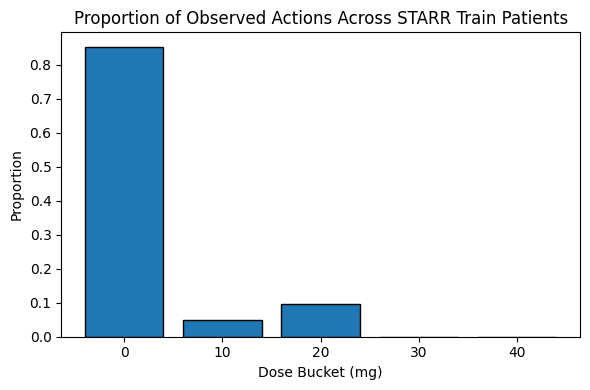

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# — STARR cohort —
# flatten all actions
starr_actions = np.concatenate([np.array(a, dtype=int)
                                for a in train_expert_trajectories['actions']])

# define every bucket (including 40)
all_buckets = np.array([0, 10, 20, 30, 40])

# compute proportions
total_starr = len(starr_actions)
starr_props = [np.sum(starr_actions == b) / total_starr for b in all_buckets]

# plot
plt.figure(figsize=(6, 4))
plt.bar(all_buckets, starr_props, width=8, edgecolor='black')
plt.xticks(all_buckets)
plt.xlabel("Dose Bucket (mg)")
plt.ylabel("Proportion")
plt.title("Proportion of Observed Actions Across STARR Train Patients")
plt.tight_layout()
plt.show()


In [58]:
import pandas as pd

# ---------------------------------------------------------------------
# 1.  Build first_k_starr  (adjust variable names if your notebook differs)
# ---------------------------------------------------------------------
K_CIDS = [3023103, 3005456]  # serum & whole-blood potassium concept_ids

first_k_starr = (
    all_labs
      .loc[all_labs['measurement_concept_id'].isin(K_CIDS)]
      .sort_values(['visit_occurrence_id', 'measurement_DATETIME'])
      .groupby('visit_occurrence_id', as_index=False)
      .first()[['visit_occurrence_id', 'value_as_number']]
      .rename(columns={'value_as_number': 'K_initial'})
)

# ---------------------------------------------------------------------
# 2.  Save to pickle (compact, preserves dtypes & index)
# ---------------------------------------------------------------------
first_k_starr.to_pickle('first_k_starr.pkl')

print(f'Saved {len(first_k_starr):,} rows to first_k_starr.pkl')
print(first_k_starr.head())


Saved 14,983 rows to first_k_starr.pkl
   visit_occurrence_id  K_initial
0              7947327        4.5
1              7952622        4.2
2              7974346        4.0
3              7976037        4.3
4              8038184        4.6


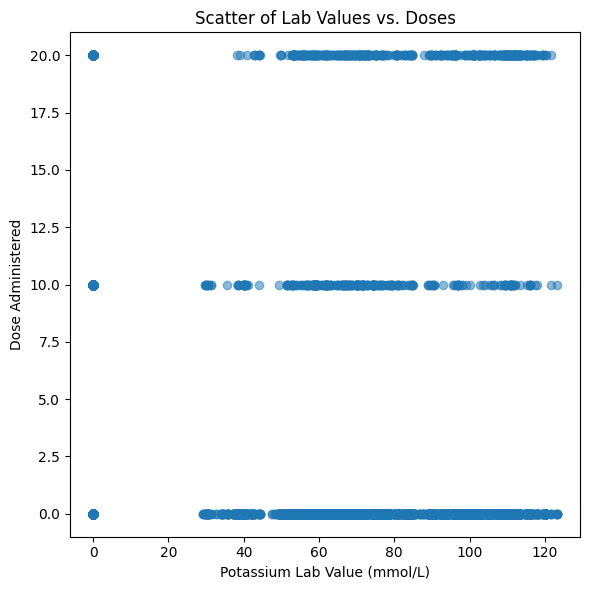

In [305]:
import numpy as np
import matplotlib.pyplot as plt

# Flatten states and actions across all patients/time steps
labs = np.concatenate([np.array(traj_states)[:,-1] 
                       for traj_states in train_expert_trajectories['states']])
actions = np.concatenate([np.array(traj_actions) 
                          for traj_actions in train_expert_trajectories['actions']])

plt.figure(figsize=(6,6))
plt.scatter(labs, actions, alpha=0.5)
plt.xlabel("Potassium Lab Value (mmol/L)")
plt.ylabel("Dose Administered")
plt.title("Scatter of Lab Values vs. Doses")
plt.tight_layout()
plt.show()


## FQI

In [306]:
# Define consistent dose-to-index mapping for both BC and FQI
dose_to_idx = {0: 0, 10: 1, 20: 2, 40: 3}
idx_to_dose = {0: 0, 1: 10, 2: 20, 3: 40}
n_actions = 4

In [307]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def build_transitions(expert_trajectories):
    """
    Given expert_trajectories = {'states', 'actions', 'rewards'}, this
    constructs a list `transitions` of (s, a, r, s2, a2, done) tuples exactly
    as in your original block.
    
    Returns:
        transitions: list of (s, a, r, s2, a2, done) tuples
    """
    transitions = []
    for states, actions, rewards in zip(
            expert_trajectories['states'],
            expert_trajectories['actions'],
            expert_trajectories['rewards']):
        T = len(states)
        for t in range(T):
            s  = np.array(states[t], dtype=np.float32)
            a  = np.array([actions[t]], dtype=np.float32)
            r  = np.array([rewards[t]], dtype=np.float32)
            done = 1.0 if t == T-1 else 0.0

            if t < T-1:
                s2 = np.array(states[t+1], dtype=np.float32)
                a2 = np.array([actions[t+1]], dtype=np.float32)
            else:
                # terminal next state/action dummy
                s2 = s.copy()
                a2 = np.array([0.0], dtype=np.float32)

            transitions.append((s, a, r, s2, a2, done))

    return transitions


In [308]:
class FQI_QNet(nn.Module):
    """Q-network for FQI policy"""
    def __init__(self, state_dim, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, n_actions)  # Q(s,a) for a ∈ {0,5,10,20,40}
        )
    def forward(self, s):
        return self.net(s)  # Shape: [batch_size, n_actions]


In [309]:
def train_fqi(transitions, num_epochs=100, lr=1e-5, batch_size=512,
              gamma=0.99, soft_tau=0.1):
    """
    Trains your FQI Q-network exactly as in the original loop, but wrapped
    so you can call it with any list of transitions.
    
    Returns:
        fqi_q_net: the trained QNet
        fqi_q_target: the final target network (after soft updates)
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Infer state_dim from the first transition tuple: (s,a,r,s2,a2,done)
    state_dim = transitions[0][0].shape[0]
    
    # Initialize FQI Q-networks
    fqi_q_net = FQI_QNet(state_dim).to(device)
    fqi_q_target = FQI_QNet(state_dim).to(device)
    fqi_q_target.load_state_dict(fqi_q_net.state_dict())
    fqi_optimizer = optim.Adam(fqi_q_net.parameters(), lr=lr)
    fqi_loss_fn = nn.MSELoss(reduction='none')  # Changed to 'none' for per-sample weighting
    
    # Compute class imbalance weights
    all_a_idx = np.array([
        dose_to_idx[t[1][0] if isinstance(t[1], (list, np.ndarray)) else t[1]]
        for t in transitions
    ])
    counts = np.bincount(all_a_idx, minlength=len(dose_to_idx))
    alpha = 0.6
    inv_freq = 1.0 / (counts.astype(np.float32) ** alpha)
    inv_freq = torch.tensor(inv_freq, dtype=torch.float32, device=device)
    
    print("Training FQI Q-network...")
    for epoch in range(num_epochs):
        np.random.shuffle(transitions)
        epoch_loss = 0.0
        n_batches = 0
        for start in range(0, len(transitions), batch_size):
            batch = transitions[start:start + batch_size]
            s, a, r, s2, a2, done = zip(*batch)
            # Convert actions to indices (0-3 or 0-4, depending on buckets)
            a_idx = np.array([
                dose_to_idx[a_elem[0] if isinstance(a_elem, (list, np.ndarray)) else a_elem]
                for a_elem in a
            ])
            a2_idx = np.array([
                dose_to_idx[a2_elem[0] if isinstance(a2_elem, (list, np.ndarray)) else a2_elem]
                for a2_elem in a2
            ])
            # Convert to tensors
            s = torch.tensor(np.array(s),    device=device, dtype=torch.float32)
            a_idx = torch.tensor(a_idx,       device=device, dtype=torch.long)
            r = torch.tensor(np.array(r),     device=device, dtype=torch.float32).squeeze(-1)
            s2 = torch.tensor(np.array(s2),   device=device, dtype=torch.float32)
            a2_idx = torch.tensor(a2_idx,     device=device, dtype=torch.long)
            done = torch.tensor(np.array(done), device=device, dtype=torch.float32)
            # Compute TD‐target: r + γ (1 − done) Q_target(s2, a2)
            with torch.no_grad():
                q2_all = fqi_q_target(s2)  # [batch_size, n_actions]
                q2 = q2_all.gather(1, a2_idx.unsqueeze(-1)).squeeze(-1)
                y = r + gamma * (1 - done) * q2
            # Current Q(s,a)
            q_all = fqi_q_net(s)  # [batch_size, n_actions]
            q = q_all.gather(1, a_idx.unsqueeze(-1)).squeeze(-1)
            
            # Weighted MSE loss for class imbalance
            loss_per_sample = fqi_loss_fn(q, y)
            sample_weights = inv_freq[a_idx]
            loss = (loss_per_sample * sample_weights).mean()
            
            fqi_optimizer.zero_grad()
            loss.backward()
            fqi_optimizer.step()
            epoch_loss += loss.item()
            n_batches += 1
        # Soft update target network
        for p, pt in zip(fqi_q_net.parameters(), fqi_q_target.parameters()):
            pt.data.mul_(1 - soft_tau)
            pt.data.add_(soft_tau * p.data)
        if epoch % 10 == 0:
            avg_loss = epoch_loss / (n_batches + 1e-8)
            print(f"[FQI] Epoch {epoch:3d}  Loss: {avg_loss:.4f}")
    return fqi_q_net, fqi_q_target

In [310]:
train_transitions = build_transitions(train_expert_trajectories)

In [311]:
bad = sum( any(np.isnan(t[0])) or np.isnan(t[2])  # t = (s,a,r,s2,a2,done)
           for t in train_transitions )
print("transitions with NaNs:", bad)


transitions with NaNs: [0]


In [312]:
len(train_transitions)

7192

In [313]:
train_fqi_net, train_fqi_target = train_fqi(train_transitions)

/var/folders/67/rsds3lxj78x4092pycb6cnkh0000gn/T/ipykernel_78117/2533482905.py:30: RuntimeWarning: divide by zero encountered in divide
  inv_freq = 1.0 / (counts.astype(np.float32) ** alpha)


Training FQI Q-network...
[FQI] Epoch   0  Loss: 25.8853
[FQI] Epoch  10  Loss: 24.9978
[FQI] Epoch  20  Loss: 24.9925
[FQI] Epoch  30  Loss: 25.1068
[FQI] Epoch  40  Loss: 24.0535
[FQI] Epoch  50  Loss: 24.6054
[FQI] Epoch  60  Loss: 24.6651
[FQI] Epoch  70  Loss: 25.1271
[FQI] Epoch  80  Loss: 23.7922
[FQI] Epoch  90  Loss: 23.7253


## BC

In [314]:
def prepare_bc_dataset(transitions, dose_to_idx):
    """
    Given `transitions = [(s,a,r,s2,a2,done), ...]`, extract:
      - bc_states: N×state_dim array of all s
      - bc_actions_idx: length‐N vector of discretized action indices
    
    Args:
        transitions: list of (s,a,r,s2,a2,done) tuples
        dose_to_idx: dict mapping raw dose → discrete index (e.g. {0:0,10:1,20:2,40:3})
    
    Returns:
        bc_states:    np.ndarray of shape [N, state_dim]
        bc_actions_idx: np.ndarray of shape [N,] with integer indices
    """
    # Stack all s_t into one (N × state_dim) array
    bc_states = np.stack([t[0] for t in transitions], axis=0)  # shape: [N, state_dim]
    
    # Extract raw action (dose) from each transition, then map to index
    raw_actions = np.stack([t[1] for t in transitions], axis=0)  # shape: [N, 1]
    bc_actions_idx = np.array([
        dose_to_idx[int(a_elem[0] if isinstance(a_elem, (list, np.ndarray)) else a_elem)]
        for a_elem in raw_actions
    ], dtype=np.int64)  # shape: [N,]
    
    # ── add dummy samples for missing action classes ─────────────────────────
    existing_actions = set(bc_actions_idx)
    all_actions = set(dose_to_idx.values())
    missing_actions = all_actions - existing_actions
    
    if missing_actions:
        print(f"Adding dummy samples for missing actions: {missing_actions}")
        state_dim = bc_states.shape[1]
        
        for missing_action in missing_actions:
            dummy_state = np.zeros((1, state_dim), dtype=np.float32)
            dummy_action = np.array([missing_action], dtype=np.int64)
            
            bc_states = np.vstack([bc_states, dummy_state])
            bc_actions_idx = np.concatenate([bc_actions_idx, dummy_action])
    # ---------------------------------------------------------------------
    
    return bc_states, bc_actions_idx

In [315]:
class BC_Policy(nn.Module):
    """Policy network for BC - outputs action probabilities"""
    def __init__(self, state_dim, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, n_actions)  # logits for each action
        )
    
    def forward(self, x):
        return self.net(x)  # Shape: [batch_size, n_actions]
    
    def get_action_probs(self, x):
        """Get action probabilities using softmax"""
        logits = self.forward(x)
        return torch.softmax(logits, dim=-1)
    
    def get_action(self, x, deterministic=False):
        """Sample action from policy"""
        probs = self.get_action_probs(x)
        if deterministic:
            action_idx = torch.argmax(probs, dim=-1)
        else:
            action_idx = torch.multinomial(probs, 1).squeeze(-1)
        return action_idx

In [316]:
def train_bc_policy(bc_states, bc_actions_idx, state_dim,
                    batch_size=512, n_epochs=100, lr=1e-3, device=None):
    """
    Train a classification BC policy to predict the discrete action index from state.
    Uses exactly the same loop as your original code, but wrapped in a function.
    
    Args:
        bc_states:       np.ndarray [N, state_dim]
        bc_actions_idx:  np.ndarray [N,]  (integer indices in [0, num_classes-1])
        state_dim:       int, dimensionality of state vector
        batch_size:      int, mini‐batch size
        n_epochs:        int, number of epochs
        lr:              float, Adam learning rate
        device:          torch.device (e.g. torch.device("cuda") or "cpu")
    
    Returns:
        bc_policy_net:   the trained BCPolicy network (nn.Module)
    """
    # Determine device
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Infer number of distinct action‐indices (classes)
    num_classes = int(bc_actions_idx.max()) + 1
    
    #compute inverse-frequency weights
    counts   = np.bincount(bc_actions_idx, minlength=n_actions)   # [n0, n1, n2, n3]
    alpha = 0.8
    weights  = 1.0 / (counts**alpha)                                       # inverse freq
    weights /= weights.mean()                                     # (optional) re-scale
    # Add these debug prints
    print(f"Global n_actions: {n_actions}")
    print(f"Computed num_classes: {num_classes}")
    print(f"bc_actions_idx range: {bc_actions_idx.min()} to {bc_actions_idx.max()}")
    print(f"counts: {counts}")
    print(f"weights: {weights}")
    print(f"Any inf/nan in weights: {np.any(np.isinf(weights)) or np.any(np.isnan(weights))}")
    
    class_w = torch.tensor(weights, dtype=torch.float32, device=device)
    print(f"class_w: {class_w}")
    
    
    # Instantiate a BCPolicy that outputs `num_classes` logits
    bc_policy_net = BC_Policy(state_dim, num_classes).to(device)
    bc_optimizer = optim.Adam(bc_policy_net.parameters(), lr=lr)
    bc_loss_fn = nn.CrossEntropyLoss(weight=class_w)
    
    # Convert to torch tensors once
    bc_states_tensor  = torch.tensor(bc_states, dtype=torch.float32, device=device)
    bc_actions_tensor = torch.tensor(bc_actions_idx, dtype=torch.long,  device=device)
    
    print("\nTraining BC Policy...")
    for epoch in range(n_epochs):
        # Shuffle indices each epoch
        perm = torch.randperm(bc_states_tensor.size(0), device=device)
        states_shuf  = bc_states_tensor[perm]
        actions_shuf = bc_actions_tensor[perm]
        
        epoch_loss = 0.0
        n_batches = 0
        
        for start in range(0, states_shuf.size(0), batch_size):
            end = start + batch_size
            s_batch = states_shuf[start:end]
            a_batch = actions_shuf[start:end]
            
            # Forward pass: get logits over discrete classes
            action_logits = bc_policy_net(s_batch)  # shape: [batch_size, num_classes]
            
            # Compute cross‐entropy loss
            loss = bc_loss_fn(action_logits, a_batch)
            
            bc_optimizer.zero_grad()
            loss.backward()
            bc_optimizer.step()
            
            epoch_loss += loss.item()
            n_batches += 1
        
        if epoch % 10 == 0:
            with torch.no_grad():
                all_logits = bc_policy_net(bc_states_tensor)
                pred_actions = torch.argmax(all_logits, dim=-1)
                accuracy = (pred_actions == bc_actions_tensor).float().mean()
                print(f"[BC] Epoch {epoch:3d}  Loss: {epoch_loss/n_batches:.4f}  "
                      f"Accuracy: {accuracy:.4f}")
    
    print("BC Training completed!\n")
    return bc_policy_net

In [317]:
# 1) Extract (states, action‐indices) for BC training

from sklearn.preprocessing import StandardScaler  # or MinMaxScaler, etc.
scaler = StandardScaler()
bc_states, bc_actions_idx = prepare_bc_dataset(train_transitions, dose_to_idx)
bc_states = scaler.fit_transform(bc_states)

state_dim = bc_states.shape[1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

bc_policy_net = train_bc_policy(
    bc_states,
    bc_actions_idx,
    state_dim,
    batch_size=512,
    n_epochs=100,
    lr=1e-3,
    device=device
)

Adding dummy samples for missing actions: {3}
Global n_actions: 4
Computed num_classes: 4
bc_actions_idx range: 0 to 3
counts: [5816  499  877    1]
weights: [3.84622798e-03 2.74317873e-02 1.74716880e-02 3.95125030e+00]
Any inf/nan in weights: False
class_w: tensor([3.8462e-03, 2.7432e-02, 1.7472e-02, 3.9513e+00])

Training BC Policy...
[BC] Epoch   0  Loss: 1.4769  Accuracy: 0.8086
[BC] Epoch  10  Loss: 1.3394  Accuracy: 0.7919
[BC] Epoch  20  Loss: 1.2068  Accuracy: 0.7553
[BC] Epoch  30  Loss: 1.1299  Accuracy: 0.7518
[BC] Epoch  40  Loss: 1.0979  Accuracy: 0.7557
[BC] Epoch  50  Loss: 1.0798  Accuracy: 0.7428
[BC] Epoch  60  Loss: 1.0684  Accuracy: 0.7478
[BC] Epoch  70  Loss: 1.0540  Accuracy: 0.7409
[BC] Epoch  80  Loss: 1.0427  Accuracy: 0.7336
[BC] Epoch  90  Loss: 1.0573  Accuracy: 0.7605
BC Training completed!



In [318]:
len(bc_states)

7193

## CQL

In [319]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from d3rlpy.algos import DiscreteCQLConfig
from d3rlpy.dataset import MDPDataset
from d3rlpy.metrics import TDErrorEvaluator
import tqdm

def prepare_dataset(expert_trajectories):
    # Define dose to index mapping
    dose_to_idx = {0:0, 10:1, 20:2, 40:3}
    
    all_states, all_actions, all_rewards, all_terminals = [], [], [], []
    for states, actions, rewards in zip(
        expert_trajectories['states'],
        expert_trajectories['actions'],
        expert_trajectories['rewards']
    ):
        L = min(len(states), len(actions), len(rewards))
        if L == 0:
            continue

        s = np.array(states[:L], dtype=np.float32)
        
        # Handle both [a] and a formats
        a = np.array([
            [dose_to_idx[a[0] if isinstance(a, (list, np.ndarray)) else a]] 
            for a in actions[:L]
        ], dtype=np.int32)
        
        r = np.array(rewards[:L], dtype=np.float32)
        t = np.zeros(L, dtype=bool)
        t[-1] = True  # mark end of episode

        all_states.append(s)
        all_actions.append(a)
        all_rewards.append(r)
        all_terminals.append(t)

    states = np.concatenate(all_states, axis=0)
    actions = np.concatenate(all_actions, axis=0)
    rewards = np.concatenate(all_rewards, axis=0)
    terminals = np.concatenate(all_terminals, axis=0)

    # Normalize states
    scaler = StandardScaler()
    norm_states = scaler.fit_transform(states)
    
    # Create MDPDataset
    dataset = MDPDataset(
        observations=norm_states,
        actions=actions,
        rewards=rewards,
        terminals=terminals
    )
    
    return dataset, scaler

In [320]:
def prepare_dataset(expert_trajectories):
    dose_to_idx = {0: 0, 10: 1, 20: 2, 40: 3}

    all_s, all_a, all_r, all_t = [], [], [], []
    for s_seq, a_seq, r_seq in zip(
            expert_trajectories['states'],
            expert_trajectories['actions'],
            expert_trajectories['rewards']):
        L = min(len(s_seq), len(a_seq), len(r_seq))
        if L == 0:
            continue

        s = np.array(s_seq[:L], dtype=np.float32)

        a = np.array(
            [dose_to_idx[a[0] if isinstance(a, (list, np.ndarray)) else a]
             for a in a_seq[:L]],
            dtype=np.int32
        )

        r = np.array(r_seq[:L], dtype=np.float32)
        t = np.zeros(L, dtype=bool); t[-1] = True

        all_s.append(s); all_a.append(a); all_r.append(r); all_t.append(t)

    states    = np.concatenate(all_s, axis=0)
    actions   = np.concatenate(all_a, axis=0)           # shape (N,)
    rewards   = np.concatenate(all_r, axis=0)
    terminals = np.concatenate(all_t, axis=0)

    # ── add one dummy sample so index 3 shows up ─────────────────────────
    dummy_obs      = np.zeros((1, states.shape[1]), dtype=np.float32)
    dummy_action   = np.array([3], dtype=np.int32)       # idx for 40 mEq
    dummy_reward   = np.array([0.0], dtype=np.float32)
    dummy_terminal = np.array([True], dtype=bool)

    states    = np.vstack([states, dummy_obs])
    actions   = np.concatenate([actions, dummy_action])
    rewards   = np.concatenate([rewards, dummy_reward])
    terminals = np.concatenate([terminals, dummy_terminal])
    # ---------------------------------------------------------------------

    # normalise
    scaler = StandardScaler()
    norm_states = scaler.fit_transform(states)

    dataset = MDPDataset(
        observations=norm_states,
        actions=actions,
        rewards=rewards,
        terminals=terminals
    )

    return dataset, scaler


In [321]:
import numpy as np
import torch

# since we handwrote FQI_QNet it is already a torch.nn.Module, ie. has fns like forward() and params() so OPE code can consume it directly.
# d3rlpy CQL isn’t a Module, it returns a scikit style python object
#the wrapper turns predict_value(s,a) → torch Q-matrix and fakes .parameters().

class CQLPolicyWrapper:
    def __init__(self, cql_model, scaler):          # ← accept scaler
        self.cql_model = cql_model
        self.scaler    = scaler
        cuda_ok = torch.cuda.is_available() and torch.backends.cuda.is_built()
        self.device = torch.device("cuda" if cuda_ok else "cpu")
        self.n_actions = len(dose_to_idx)

    def parameters(self):
        yield torch.tensor(0.0, device=self.device)

    def __call__(self, states_tensor: torch.Tensor) -> torch.Tensor:
        states_np  = states_tensor.detach().cpu().numpy()
        # --- NEW: match training preprocessing --------------------------
        states_np  = self.scaler.transform(states_np)
        # ----------------------------------------------------------------
        batch_size = states_np.shape[0]

        q_list = []
        for action_idx in range(self.n_actions):
            action_arr = np.full(batch_size, action_idx, dtype=np.int32)
            q_vals = self.cql_model.predict_value(states_np, action_arr)
            q_list.append(q_vals)

        q_matrix = np.stack(q_list, axis=1)
        return torch.tensor(q_matrix, device=self.device, dtype=torch.float32)


In [322]:
from d3rlpy.models.encoders import DefaultEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory

def run_discrete_cql(expert_trajectories, n_epochs=20, use_gpu=False):
    # Prepare dataset
    dataset, scaler = prepare_dataset(expert_trajectories)
    
    # Setup Discrete CQL with verified v2.x parameters
    cql = DiscreteCQLConfig(
        batch_size=512,
        learning_rate=3e-4,
        n_critics=2,                # Number of Q functions
        target_update_interval=10000,
        observation_scaler=None,     # We already scaled manually
        alpha=1.0,                  # CQL regularization weight
        q_func_factory=MeanQFunctionFactory(),  # Must be factory object
        encoder_factory=DefaultEncoderFactory() # Must be factory object, not string
    ).create(device="cuda" if use_gpu else "cpu")
    
    # Calculate total steps
    episodes = dataset.episodes
    N = sum(len(ep.observations) for ep in episodes)
    total_steps = n_epochs * N
    
    # Setup evaluator
    td_error_evaluator = TDErrorEvaluator(episodes[:10])
    
    print(f"Training Discrete CQL for ~{n_epochs} epochs ({total_steps} steps)...")
    cql.fit(
        dataset,
        n_steps=total_steps,
        evaluators={"td_error": td_error_evaluator},
        show_progress=True
    )
    
    return cql, scaler

In [323]:
cql_model, scaler = run_discrete_cql(train_expert_trajectories, n_epochs=10, use_gpu=False)

2025-06-09 12:41.47 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(10,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)])
2025-06-09 12:41.47 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-06-09 12:41.47 [info     ] Action size has been automatically determined. action_size=4
Training Discrete CQL for ~10 epochs (71930 steps)...
2025-06-09 12:41.47 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(10,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=4)
2025-06-09 12:41.47 [debug    ] Building models...            
2025-06-09 12:41.47 [debug    ] Mode

Epoch 1/7: 100%|█| 10000/10000 [01:59<00:00, 83.43it/s, loss=55.7, td_loss=55.1,


2025-06-09 12:43.47 [info     ] DiscreteCQL_20250609124147: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0039799513578414915, 'time_algorithm_update': 0.007807189726829529, 'loss': 55.68630433921814, 'td_loss': 55.06381105384827, 'conservative_loss': 0.6224932916939259, 'time_step': 0.011924936318397522, 'td_error': 3518.768163686282} step=10000
2025-06-09 12:43.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250609124147/model_10000.d3


Epoch 2/7: 100%|█| 10000/10000 [01:57<00:00, 84.80it/s, loss=51.2, td_loss=50.5,


2025-06-09 12:45.45 [info     ] DiscreteCQL_20250609124147: epoch=2 step=20000 epoch=2 metrics={'time_sample_batch': 0.00438457465171814, 'time_algorithm_update': 0.007216559076309204, 'loss': 51.152131099319455, 'td_loss': 50.49156402282715, 'conservative_loss': 0.6605670826405287, 'time_step': 0.011732201290130615, 'td_error': 3690.310272834695} step=20000
2025-06-09 12:45.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250609124147/model_20000.d3


Epoch 3/7: 100%|█| 10000/10000 [02:01<00:00, 82.28it/s, loss=54.9, td_loss=54.2,

2025-06-09 12:47.47 [info     ] DiscreteCQL_20250609124147: epoch=3 step=30000 epoch=3 metrics={'time_sample_batch': 0.004399608278274536, 'time_algorithm_update': 0.007546827173233032, 'loss': 54.85610343017578, 'td_loss': 54.147919425201415, 'conservative_loss': 0.7081840083718299, 'time_step': 0.012091004061698914, 'td_error': 4032.884689370001} step=30000
2025-06-09 12:47.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250609124147/model_30000.d3



Epoch 4/7: 100%|█| 10000/10000 [01:55<00:00, 86.25it/s, loss=58.8, td_loss=58, c

2025-06-09 12:49.43 [info     ] DiscreteCQL_20250609124147: epoch=4 step=40000 epoch=4 metrics={'time_sample_batch': 0.0043908464431762695, 'time_algorithm_update': 0.007012959861755371, 'loss': 58.77915601615906, 'td_loss': 57.999324447631835, 'conservative_loss': 0.7798315740019083, 'time_step': 0.011535285663604736, 'td_error': 4415.594650175176} step=40000
2025-06-09 12:49.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250609124147/model_40000.d3



Epoch 5/7: 100%|█| 10000/10000 [01:58<00:00, 84.40it/s, loss=62.7, td_loss=61.8,

2025-06-09 12:51.41 [info     ] DiscreteCQL_20250609124147: epoch=5 step=50000 epoch=5 metrics={'time_sample_batch': 0.004517614221572876, 'time_algorithm_update': 0.007131673216819763, 'loss': 62.67924638519287, 'td_loss': 61.842159238815306, 'conservative_loss': 0.8370871537029744, 'time_step': 0.011783483409881591, 'td_error': 4803.828394976296} step=50000
2025-06-09 12:51.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250609124147/model_50000.d3



Epoch 6/7: 100%|█| 10000/10000 [02:01<00:00, 82.24it/s, loss=65.5, td_loss=64.6,


2025-06-09 12:53.43 [info     ] DiscreteCQL_20250609124147: epoch=6 step=60000 epoch=6 metrics={'time_sample_batch': 0.004545941519737244, 'time_algorithm_update': 0.007411949157714844, 'loss': 65.52705821113587, 'td_loss': 64.63057712440491, 'conservative_loss': 0.8964811037302017, 'time_step': 0.012094832491874695, 'td_error': 5265.685555208936} step=60000
2025-06-09 12:53.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250609124147/model_60000.d3


Epoch 7/7: 100%|█| 10000/10000 [02:08<00:00, 77.79it/s, loss=68.4, td_loss=67.4,

2025-06-09 12:55.51 [info     ] DiscreteCQL_20250609124147: epoch=7 step=70000 epoch=7 metrics={'time_sample_batch': 0.0047200078248977664, 'time_algorithm_update': 0.007921659278869628, 'loss': 68.36086922607421, 'td_loss': 67.39877631912232, 'conservative_loss': 0.9620928686380387, 'time_step': 0.012784590482711793, 'td_error': 5721.381039071926} step=70000
2025-06-09 12:55.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250609124147/model_70000.d3


In [324]:
#Create wrapper for OPE compatibility
cql_wrapper = CQLPolicyWrapper(cql_model, scaler)
# After running, check action space size is correct (should be 4)
print("Action space size:", cql_model.impl.action_size) 

Action space size: 4


## OPE: Weighted Importance Sampling

In [325]:
import numpy as np
import torch
import torch.nn.functional as F

def compute_policy_probabilities(policy_net, states, actions, policy_type='bc'):
    """
    Compute π(a|s) for given states and actions
    
    Args:
        policy_net: trained policy network (BC, FQI or CQL)
        states: numpy array of states [N, state_dim]
        actions: numpy array of actions [N, 1] 
        policy_type: 'bc', 'fqi' or 'cql'
    
    Returns:
        probabilities: numpy array of π(a|s) values [N,]
    """
    device = next(policy_net.parameters()).device
    states_tensor = torch.tensor(states, dtype=torch.float32, device=device)
    
    with torch.no_grad():            
        if policy_type == 'bc':
            logits = policy_net(states_tensor)                 # [N, 4]
            probs  = F.softmax(logits, dim=1)                  # [N, 4]
            #print(probs.shape)
            # map raw dose to its discrete index once
            action_indices = torch.tensor(
                [dose_to_idx[int(a[0])] for a in actions],
                dtype=torch.long, device=device
            )                                                  # [N,]
            # probability assigned to the taken action
            action_probs = probs.gather(1, action_indices.unsqueeze(1)).squeeze(1)
            
        elif policy_type == 'fqi':
            # For FQI: use epsilon-greedy or softmax policy based on Q-values
            q_values = policy_net(states_tensor)  # [N, 4]
            #print(q_values.shape)
            
            # Softmax policy (more common for continuous evaluation)
            temperature = 1.0  # adjust as needed
            probs = F.softmax(q_values / temperature, dim=1)  # [N, 4]
            
            # Get probability for actual action taken
            action_indices = torch.tensor([dose_to_idx[int(a[0])] for a in actions], 
                                        dtype=torch.long, device=device)
            action_probs = probs.gather(1, action_indices.unsqueeze(1)).squeeze(1)
        
        elif policy_type == 'cql':
            # Same logic as FQI – convert CQL Q-values to a softmax policy
            q_values = policy_net(states_tensor)               # [N, 4]
            temperature = 1.0
            probs = F.softmax(q_values / temperature, dim=1)   # [N, 4]

            action_indices = torch.tensor(
                [dose_to_idx[int(a[0])] for a in actions],
                dtype=torch.long, device=device
            )
            action_probs = probs.gather(1, action_indices.unsqueeze(1)).squeeze(1)
    
    return action_probs.cpu().numpy()

def compute_importance_weights(bc_policy_net,
                               target_q_net,                # was fqi_q_net
                               expert_trajectories,
                               target_type='fqi'):          # allows 'fqi' or 'cql'
    """
    Importance-sampling weights for each trajectory.

    Args
    ----
    bc_policy_net   : trained BC network (behaviour policy)
    target_q_net    : trained Q-value network from FQI, CQL, etc. (target policy)
    expert_trajectories : dict with keys 'states', 'actions', 'rewards'
    target_type     : string passed to `compute_policy_probabilities`
                      ('fqi' by default, set to 'cql' when evaluating CQL)

    Returns
    -------
    weights          : list of raw importance weights  (one per trajectory)
    clipped_weights  : same list after clipping
    """
    trajectory_weights          = []
    trajectory_weights_clipped  = []

    for states, actions, rewards in zip(expert_trajectories['states'],
                                        expert_trajectories['actions'],
                                        expert_trajectories['rewards']):

        if len(states) == 0:        # skip empty trajectories
            continue

        #convert to numpy arrays
        states_np  = np.asarray(states,  dtype=np.float32)
        actions_np = np.asarray([[a] for a in actions], dtype=np.float32)

        # Compute policy probabilities
        pi_b      = compute_policy_probabilities(bc_policy_net, states_np, actions_np, 'bc') #pi_b = behavior policy/ expert policy
        pi_e  = compute_policy_probabilities(target_q_net, states_np, actions_np, target_type) #pi_e = evaluation policy/ target policy

        # Avoid division by zero
        pi_b     = np.maximum(pi_b, 1e-8)
        pi_e = np.maximum(pi_e, 1e-8)

        # Per-trajectory weight  ∏_t  π_t / π_b
        weight            = np.prod(pi_e / pi_b)
        weight_clipped    = np.clip(weight, 0.1, 10.0) # Clip weights to prevent extreme values (common in practice)

        trajectory_weights.append(weight)
        trajectory_weights_clipped.append(weight_clipped)

    return trajectory_weights, trajectory_weights_clipped


def importance_sampling_estimator(expert_trajectories, weights, use_clipped=True):
    """
    Compute IS and WIS estimators of policy value
    
    Args:
        expert_trajectories: dict with 'states', 'actions', 'rewards'
        weights: list of importance weights for each trajectory
        use_clipped: whether to use clipped weights
    
    Returns:
        is_estimate: basic importance sampling estimate
        wis_estimate: weighted importance sampling estimate
    """
    trajectory_returns = []
    valid_weights = []
    
    # Compute returns for each trajectory
    for traj_idx, (states, actions, rewards) in enumerate(zip(
        expert_trajectories['states'],
        expert_trajectories['actions'],
        expert_trajectories['rewards']
    )):
        if len(rewards) == 0:
            continue
            
        # Compute discounted return
        gamma = 0.99
        discounted_return = 0.0
        for t, reward in enumerate(rewards):
            discounted_return += (gamma ** t) * reward
        
        trajectory_returns.append(discounted_return)
        valid_weights.append(weights[traj_idx])
    
    trajectory_returns = np.array(trajectory_returns)
    valid_weights = np.array(valid_weights)
    
    # Basic IS estimator: (1/N) * Σ(w_i * R_i)
    is_estimate = np.mean(valid_weights * trajectory_returns)
    
    # Weighted IS estimator: Σ(w_i * R_i) / Σ(w_i)
    wis_estimate = np.sum(valid_weights * trajectory_returns) / np.sum(valid_weights)
    
    return is_estimate, wis_estimate

    
def evaluate_policies_with_ope(bc_policy_net, target_q_net, expert_trajectories, target_type):
    """
    Complete OPE evaluation pipeline
    """
    print("Computing importance sampling weights...")
    weights, weights_clipped = compute_importance_weights(bc_policy_net, target_q_net, expert_trajectories, target_type)
    
    print(f"Weight statistics:")
    print(f"  Unclipped: mean={np.mean(weights):.4f}, std={np.std(weights):.4f}")
    print(f"  Clipped:   mean={np.mean(weights_clipped):.4f}, std={np.std(weights_clipped):.4f}")
    
    # Evaluate with unclipped weights
    is_est, wis_est = importance_sampling_estimator(expert_trajectories, weights, use_clipped=False)
    print(f"\nUnclipped weights:")
    print(f"  IS estimate:  {is_est:.4f}")
    print(f"  WIS estimate: {wis_est:.4f}")
    
    # Evaluate with clipped weights  
    is_est_clip, wis_est_clip = importance_sampling_estimator(expert_trajectories, weights_clipped, use_clipped=True)
    print(f"\nClipped weights:")
    print(f"  IS estimate:  {is_est_clip:.4f}")
    print(f"  WIS estimate: {wis_est_clip:.4f}")
    
    return {
        'weights': weights,
        'weights_clipped': weights_clipped,
        'is_unclipped': is_est,
        'wis_unclipped': wis_est,
        'is_clipped': is_est_clip,
        'wis_clipped': wis_est_clip
    }


In [326]:
results = evaluate_policies_with_ope(bc_policy_net, train_fqi_net, train_expert_trajectories, 'fqi')

Computing importance sampling weights...
Weight statistics:
  Unclipped: mean=inf, std=nan
  Clipped:   mean=5.0241, std=4.9390

Unclipped weights:
  IS estimate:  inf
  WIS estimate: nan

Clipped weights:
  IS estimate:  8523.4746
  WIS estimate: 1696.5240


/opt/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/miniconda3/lib/python3.12/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/var/folders/67/rsds3lxj78x4092pycb6cnkh0000gn/T/ipykernel_78117/2446852946.py:152: RuntimeWarning: overflow encountered in multiply
  is_estimate = np.mean(valid_weights * trajectory_returns)
/var/folders/67/rsds3lxj78x4092pycb6cnkh0000gn/T/ipykernel_78117/2446852946.py:155: RuntimeWarning: overflow encountered in multiply
  wis_estimate = np.sum(valid_weights * trajectory_returns) / np.sum(valid_weights)
/var/folders/67/rsds3lxj78x4092pycb6cnkh0000gn/T/ipykernel_78117/2446852946.py:155: RuntimeWarning: invalid value encountered in scalar divide
  wis_estimate = np.sum(valid_weights * trajectory_returns) / np.sum(valid_weights)


In [327]:
results = evaluate_policies_with_ope(bc_policy_net, cql_wrapper, train_expert_trajectories, 'cql')

Computing importance sampling weights...
Weight statistics:
  Unclipped: mean=inf, std=nan
  Clipped:   mean=9.2702, std=2.5221

Unclipped weights:
  IS estimate:  inf
  WIS estimate: nan

Clipped weights:
  IS estimate:  13659.7305
  WIS estimate: 1473.5112


/opt/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning

In [328]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch


def plot_action_distributions(expert_trajectories,
                              fqi_model,
                              bc_model,
                              cql_wrapper,
                              scaler):
    """
    Draw 4 side-by-side histograms (2×2 grid) of dose selection:
        ▸ Clinician  ▸ BC  ▸ FQI  ▸ CQL
    Uses a common random subset of states so the distributions are
    directly comparable.  Colour scheme:
        blue = clinician, orange = BC, green = FQI, red = CQL
    """
    dose_buckets = [0, 10, 20, 40]
    bins = [-5, 5, 15, 30, 50]

    # ── sample identical state set ──────────────────────────────────────
    raw_states = np.concatenate(expert_trajectories["states"])
    raw_actions = np.concatenate(expert_trajectories["actions"]).flatten()

    perm = np.random.permutation(len(raw_states))
    raw_states = raw_states[perm]
    raw_actions = raw_actions[perm]

    scaled_states = scaler.transform(raw_states)

    # ── clinician actions ───────────────────────────────────────────────
    clinician_doses = raw_actions

    # BC predictions  ► use argmax over logits
    with torch.no_grad():
        logits = bc_model(torch.tensor(scaled_states, dtype=torch.float32)).cpu().numpy()
    bc_doses = np.array([dose_buckets[idx] for idx in np.argmax(logits, axis=1)])


    # ── FQI predictions (arg-max Q) ─────────────────────────────────────
    with torch.no_grad():
        q_vals = fqi_model(torch.tensor(raw_states,
                                        dtype=torch.float32)).cpu().numpy()
    fqi_doses = np.array([dose_buckets[np.argmax(q)] for q in q_vals])

    # ── CQL predictions (wrapper Q-matrix) ──────────────────────────────
    with torch.no_grad():
        q_cql = cql_wrapper(torch.tensor(raw_states,
                                         dtype=torch.float32)).cpu().numpy()
    cql_doses = np.array([dose_buckets[i] for i in np.argmax(q_cql, axis=1)])

    # ── plotting (4 quadrants) ──────────────────────────────────────────
    fig, axes = plt.subplots(2, 2, figsize=(10, 7))
    plots = [
        (axes[0, 0], clinician_doses, "Clinician", "tab:blue"),
        (axes[0, 1], bc_doses,        "BC",        "tab:orange"),
        (axes[1, 0], fqi_doses,       "FQI",       "tab:green"),
        (axes[1, 1], cql_doses,       "CQL",       "tab:red"),
    ]

    for ax, doses, label, color in plots:
        sns.histplot(
            doses,
            bins=bins,
            stat="probability",
            discrete=True,
            shrink=0.8,
            edgecolor="k",
            color=color,
            alpha=0.5,
            ax=ax
        )
        ax.set_title(f"{label} (n={len(doses)})")
        ax.set_xticks(dose_buckets)
        ax.set_xlim(-5, 45)
        ax.set_xlabel("Dose (mEq)")
        ax.set_ylabel("Proportion")

        # mark mean
        mean_dose = np.mean(doses)
        ax.axvline(mean_dose, color=color, linestyle="--", alpha=0.7)
        ax.text(mean_dose + 1.5,
                ax.get_ylim()[1] * 0.9,
                f"{mean_dose:.1f}",
                color=color,
                fontsize=8)

    plt.tight_layout()
    plt.show()


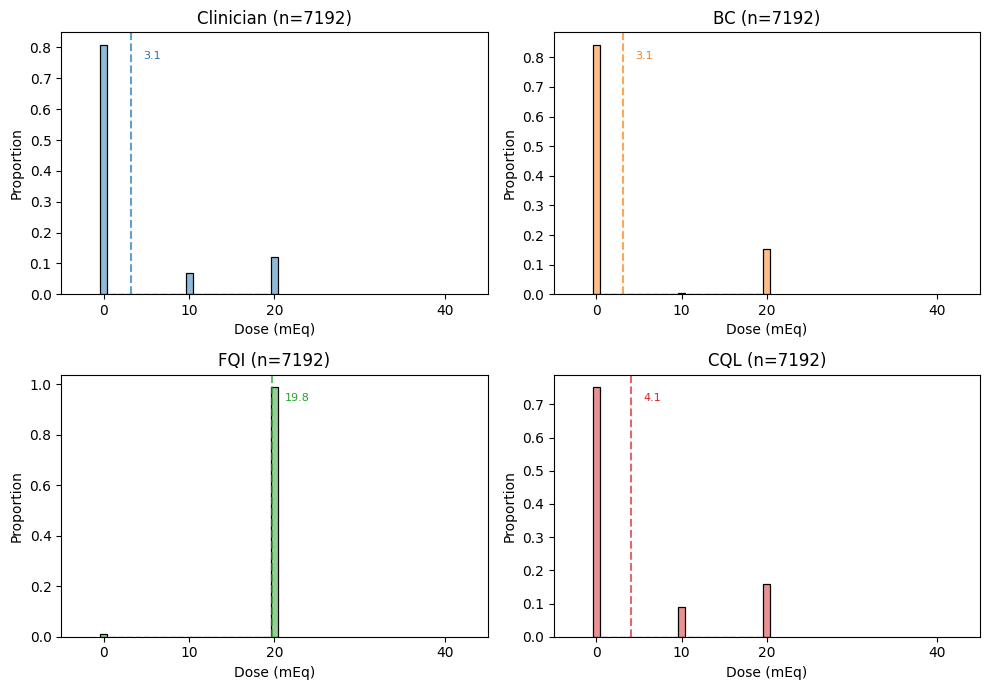

In [329]:
# ------------------------------------------------------------
# Assume these objects already exist in your notebook session:
#   • train_expert_trajectories   (dict with 'states' 'actions' 'rewards')
#   • train_fqi_net               (torch nn.Module, discrete Q-network)
#   • bc_model                    (torch nn.Module, behaviour-cloning net)
#   • cql_model                   (d3rlpy DiscreteCQL model, already fitted)
#   • scaler                      (sklearn StandardScaler fitted on states)
#   • device                     = "cuda" or "cpu" — whichever you used
# ------------------------------------------------------------

plot_action_distributions(
    expert_trajectories=train_expert_trajectories,
    fqi_model=train_fqi_net,
    bc_model=bc_policy_net,
    cql_wrapper=cql_wrapper,
    scaler=scaler,
)
